이 자료는 [FirmAI](https://www.firmai.org/)의 [financial-machine-learning](https://github.com/firmai/financial-machine-learning) 깃헙의 [RL Trading](https://colab.research.google.com/drive/1FzLCI0AO3c7A4bp9Fi01UwXeoc7BN8sW)을 번역한 것입니다.

이 노트북은 [기계 학습 자산 관리(Machine Learning in Asset Management)](https://ssrn.com/abstract=3420952)에 대한 시리즈의 일부입니다.

여기에는 25개 이상의 강화학습 기반 트레이딩 전략들이 구현되어있습니다. 

또한, 오픈 소스 강화학습 프레임워크들을 비교한 [스프레드 시트](https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0
)도 공유해줍니다.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
sns.set()

## Trading Strategies

In [3]:
!pip install yfinance --upgrade --no-cache-dir

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=5ebb9654d30e6c5d9818791af595f079770768324e9764d957b36006656f8433
  Stored in directory: /tmp/pip-ephem-wheel-cache-1wnvtc3r/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


먼저 yfinance 패키지를 설치해줍니다. yfinance 패키지는 [Yahoo! Finance market data downloader](https://github.com/ranaroussi/yfinance) 입니다. 

yfinance는 Yahoo Finance에서 과거 시장 데이터를 다운로드 할 수 있는 안정적이고 스레드, Python 방식을 제공하여 문제를 해결하는 것을 목표로 합니다.

In [4]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%cd "/content/drive/My Drive/0_colab/FinML/"

/content/drive/My Drive/0_colab/FinML


In [6]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("JPM", start="2018-01-01").reset_index()
df_full.to_csv('output/JPM.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,107.629997,108.019997,106.809998,107.949997,101.684258,13578800
1,2018-01-03,107.860001,108.489998,107.480003,108.059998,101.787872,11901000
2,2018-01-04,108.360001,110.029999,108.199997,109.040001,103.246048,12953700
3,2018-01-05,109.260002,109.550003,107.779999,108.339996,102.583244,14155000
4,2018-01-08,108.150002,108.680000,107.699997,108.500000,102.734734,12466500


get_data_yahoo()라는 간단한 함수로, 2018년 1월 1일부터의 JP 모건의 데이터를 가져왔습니다. 일단위로 시가, 고가, 저가, 종가, 종가 조정, 거래량이 나오네요.

In [0]:
df_full = pd.read_csv('output/JPM.csv')

#  Agents

* Turtle Trading agent
* Moving Average agent
* Signal Rolling agent
* Policy Gradient agent
* Q-learning agent
* Evolution Strategy agent
* Double Q-learning agent
* Recurrent Q-learning agent
* Double Recurrent Q-learning agent
* Duel Q-learning agent
* Double Duel Q-learning agent
* Duel Recurrent Q-learning agent
* Double Duel Recurrent Q-learning agent
* Actor-critic agent
* Actor-critic Duel agent
* Actor-critic Recurrent agent
* Actor-critic Duel Recurrent agent
* Curiosity Q-learning agent
* Recurrent Curiosity Q-learning agent
* Duel Curiosity Q-learning agent
* Neuro-evolution agent
* Neuro-evolution with Novelty search agent
* ABCD strategy agent
* Deep Evolution Strategy






# Helper Function

In [0]:
def plot_price_pvs(name, close, states_buy, states_sell, total_gains, invest, pvs, invs):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,8), constrained_layout=True)

    axs[0].plot(close, color='r', lw=2.)
    axs[0].plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    axs[0].plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    axs[0].legend()
    axs[0].set_title('total gains %f, total investment %f%%'%(total_gains, invest))

    axs[1].plot(pvs, color='r', lw=2.)
    axs[1].set_ylabel('PV')
    ax = axs[1].twinx()
    ax.plot(invs, color='b', lw=2., label = 'Stocks')
    ax.set_ylabel('Q')

    #plt.tight_layout()
    #plt.subplots_adjust(top=.9)
    plt.savefig('output/'+name+'_q_pv.png')
    plt.show()

In [0]:
def plot_train_pvs(name, pvs):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,8), constrained_layout=True)

    #axs.set_title('total gains %f, total investment %f%%'%(total_gains, invest))

    axs.plot(pvs, color='r', lw=2.)
    axs.set_ylabel('PV')

    plt.savefig('output/'+name+'_tr_pv.png')
    plt.show()

# 1 Simple Stragegy

## 1.1 Turtle Trading Agent

Turtle Trading은 트레이딩의 한 기법으로 매우 고전적인 방법입니다. 1983년에 Richard Dennis와 William Eckhardt가 거북이 실험(turtle experiment)를 수행했습니다. 이 실험은 누구나 트레이드(주식 거래)를 배울 수 있다는 것을 증명하기 위한 것이었습니다. 7 단계의 간단한 추론 방법인데 과정은 다음과 같습니다.

1. 질문 정의
2. 정보와 자료 수집
3. 형태 가설(Form hypothesis)
4. 실험 수행 및 데이터 수집
5. 데이터 분석
6. 데이터를 해석하고 결론을 도출(새로운 가설의 출발점으로 작용)
7. 결과를 게시

그리고 Eckhardt는 용어를 간단히 정의합니다.

1. 시장의 상태: 시장이 거래하는 가격
2. 시장의 변동성: 고가 - 저가

ref: https://www.investopedia.com/articles/trading/08/turtle-trading.asp

ref: https://www.turtletrader.com/rules/

rolling window를 통해 고가와 저가를 기록하고, 그것보다 낮거나 높을 때 매수를 하는 방식
* 전체 데이터수의 10% 에 해당하는 수량을 rolling 갯수로 사용함
* rolling 범위의 최대값 초과이면 매도 signal
* rolling 범위의 최소값 미만이면 매수 signal

In [9]:
df= df_full.copy()
name = 'Turtle Trading Agent'
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,107.949997,NaN,NaN
1,0.0,108.059998,NaN,NaN
2,0.0,109.040001,NaN,NaN
3,0.0,108.339996,NaN,NaN
4,0.0,108.500000,NaN,NaN
...,...,...,...,...
541,1.0,121.370003,141.089996,126.260002
542,1.0,116.110001,141.089996,121.370003
543,0.0,121.519997,141.089996,116.110001
544,0.0,116.959999,141.089996,116.110001


주식을 매수하는 함수입니다.

- real_movement = 실제 세계에서의 실제 움직임
- signal = 1은 매수, -1은 매도
- initial_money = 초기 자본
- max_buy = 구매할 최대 수량
- max_sell = 판매할 최대 수량

In [0]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):

    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    pvs = []
    invs = []
    last_pv = 0
    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
        # Portfolio Value, 보유 주식수 갱신
        last_pv = initial_money + current_inventory*real_movement[i]
        pvs.append(last_pv)
        invs.append(current_inventory)

    #total_gains = initial_money - starting_money
    #invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = last_pv - starting_money
    invest = (total_gains / starting_money) * 100
    return states_buy, states_sell, total_gains, invest, pvs, invs

In [11]:
states_buy, states_sell, total_gains, invest, pvs, invs = buy_stock(df.Close, signals['signal'])

day 56: buy 1 units at price 107.010002, total balance 9892.989998
day 101: buy 1 units at price 105.930000, total balance 9787.059998
day 119: buy 1 units at price 105.750000, total balance 9681.309998
day 120: buy 1 units at price 104.790001, total balance 9576.519997
day 122: buy 1 units at price 103.239998, total balance 9473.279999
day 141, sell 1 units at price 115.180000, investment 11.565287 %, total balance 9588.459999,
day 143, sell 1 units at price 116.029999, investment 12.388610 %, total balance 9704.489998,
day 144, sell 1 units at price 116.730003, investment 13.066646 %, total balance 9821.220001,
day 148, sell 1 units at price 117.089996, investment 13.415341 %, total balance 9938.309997,
day 149, sell 1 units at price 117.120003, investment 13.444406 %, total balance 10055.430000,
day 150: cannot sell anything, inventory 0
day 151: cannot sell anything, inventory 0
day 181: cannot sell anything, inventory 0
day 195: buy 1 units at price 111.470001, total balance 9943.

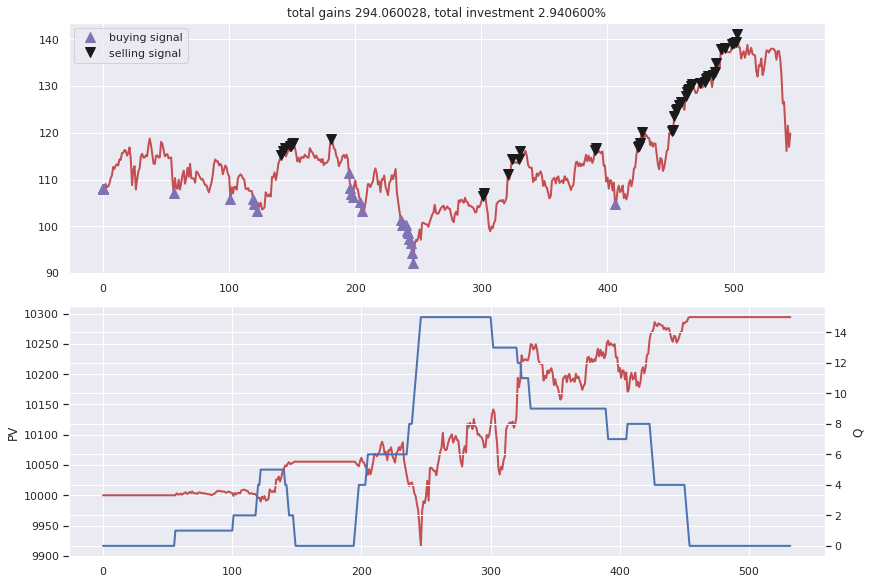

In [12]:
plot_price_pvs(name, df.Close, states_buy, states_sell, total_gains, invest, pvs, invs)

* 빨강색 : Portfolio Value(예수금+주식평가액)
* 파란색 : 보유 주식수

## 1.2 Moving Average agent

단기, 장기 이동평균 교차를 이용하여 거래하는 방식
* 단기이평 rolling window 수 : 전체 데이터수의 2.5% 
* 장기이평 rolling window 수 : 전체 데이터수의 5% 
* signal : 단기이평 > 장기이평 이면 1, 아니면 0
* positions : golden cross 이면 1, dead cross 이면 -1

In [13]:
df= df_full.copy()
name = 'Moving Average agent'

short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,107.949997,107.949997,NaN
1,0.0,108.004998,108.004998,0.0
2,0.0,108.349999,108.349999,0.0
3,0.0,108.347498,108.347498,0.0
4,0.0,108.377998,108.377998,0.0
...,...,...,...,...
541,0.0,133.995387,134.634073,0.0
542,0.0,132.331541,133.866296,0.0
543,0.0,131.063848,133.304814,0.0
544,0.0,129.445386,132.579629,0.0


In [0]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):

    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    pvs = []
    invs = []
    last_pv = 0
    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)

        # Portfolio Value, 보유 주식수 갱신
        last_pv = initial_money + current_inventory*real_movement[i]
        pvs.append(last_pv)
        invs.append(current_inventory)

    #total_gains = initial_money - starting_money
    #invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = last_pv - starting_money
    invest = (total_gains / starting_money) * 100
    return states_buy, states_sell, total_gains, invest, pvs, invs

In [15]:
states_buy, states_sell, total_gains, invest, pvs, invs = buy_stock(df.Close, signals['positions'])

day 13: buy 1 units at price 114.330002, total balance 9885.669998
day 31, sell 1 units at price 115.510002, investment 1.032100 %, total balance 10001.180000,
day 39: buy 1 units at price 115.500000, total balance 9885.680000
day 55, sell 1 units at price 109.949997, investment -4.805197 %, total balance 9995.629997,
day 78: buy 1 units at price 109.989998, total balance 9885.639999
day 83, sell 1 units at price 107.919998, investment -1.881989 %, total balance 9993.559997,
day 93: buy 1 units at price 113.339996, total balance 9880.220001
day 105, sell 1 units at price 108.449997, investment -4.314451 %, total balance 9988.669998,
day 137: buy 1 units at price 109.889999, total balance 9878.779999
day 164, sell 1 units at price 116.709999, investment 6.206206 %, total balance 9995.489998,
day 184: buy 1 units at price 116.389999, total balance 9879.099999
day 195, sell 1 units at price 111.470001, investment -4.227166 %, total balance 9990.570000,
day 219: buy 1 units at price 109.58

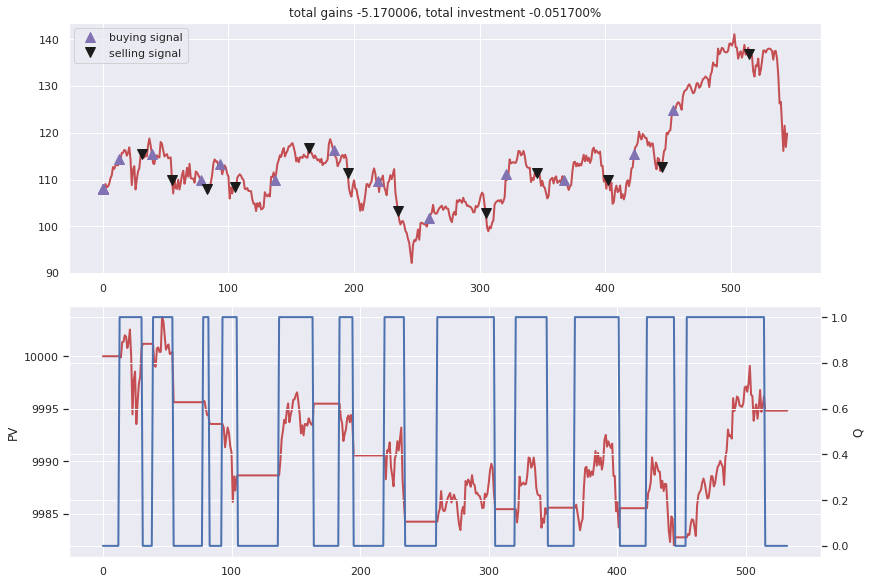

In [16]:
plot_price_pvs(name, df.Close, states_buy, states_sell, total_gains, invest, pvs, invs)

## 1.3 Signal Rolling agent

매수 매도 신호가 delay 만큼 유지되면 실제 거래함
* state 초기값은 1(매수)로 설정함
* 현재가 < 이전가 인 상황이 delay 만큼 유지되었으면 매수
* 현재가 > 이전가 인 상황이 delay 만큼 유지되었으면 매도

In [0]:
df= df_full.copy()
name = 'Signal Rolling agent'

주식을 매수하는 함수입니다.

- real_movement = 실제 세계에서의 실제 움직임
- delay = 구매에서 판매로(또는 그 반대로) 결정을 변경하기 위해 지연하려는 간격
- initial_state = 1은 매수, 0은 매도
- initial_money = 초기 자본
- max_buy = 구매할 최대 수량
- max_sell = 판매할 최대 수량

In [0]:
def buy_stock(
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    pvs = []
    invs = []
    last_pv = 0
    for i in range(1, real_movement.shape[0], 1):
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
            
        # Portfolio Value, 보유 주식수 갱신
        last_pv = initial_money + current_inventory*real_movement[i]
        pvs.append(last_pv)
        invs.append(current_inventory)

    #total_gains = initial_money - starting_money
    #invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = last_pv - starting_money
    invest = (total_gains / starting_money) * 100
    return states_buy, states_sell, total_gains, invest, pvs, invs

In [18]:
states_buy, states_sell, total_gains, invest, pvs, invs = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 4, initial_money = 10000)

day 0: buy 1 units at price 107.949997, total balance 9892.050003
day 6, sell 1 units at price 110.250000, investment 2.130619 %, total balance 10002.300003,
day 19: buy 1 units at price 115.110001, total balance 9887.190002
day 27, sell 1 units at price 110.040001, investment -4.404483 %, total balance 9997.230003,
day 40: buy 1 units at price 113.430000, total balance 9883.800003
day 50, sell 1 units at price 115.239998, investment 1.595696 %, total balance 9999.040001,
day 59: buy 1 units at price 108.000000, total balance 9891.040001
day 66, sell 1 units at price 110.400002, investment 2.222224 %, total balance 10001.440003,
day 75: buy 1 units at price 111.470001, total balance 9889.970002
day 88, sell 1 units at price 113.410004, investment 1.740381 %, total balance 10003.380006,
day 98: buy 1 units at price 112.489998, total balance 9890.890008
day 108, sell 1 units at price 110.800003, investment -1.502351 %, total balance 10001.690011,
day 114: buy 1 units at price 107.900002,

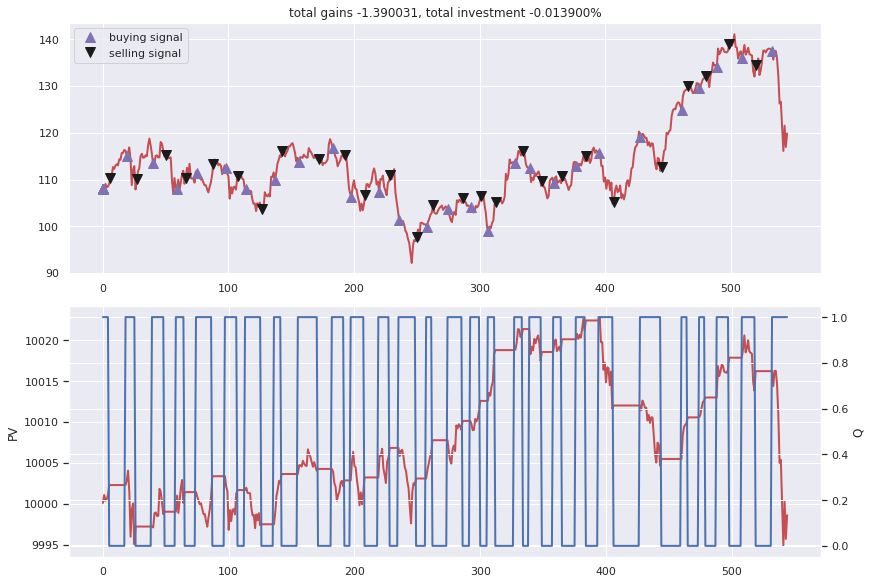

In [19]:
plot_price_pvs(name, df.Close, states_buy, states_sell, total_gains, invest, pvs, invs)

# 2 Q-learning

In [20]:
import tensorflow as tf

## 2.1 Policy Gradient agent

In [0]:
df = df_full.copy()
name = 'Policy Gradient agent'
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)

        pvs = []
        invs = []
        last_pv = 0
        current_inventory = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                current_inventory += 1
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                current_inventory -= 1
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state

            # Portfolio Value, 보유 주식수 갱신
            last_pv = initial_money + current_inventory*self.trend[t]
            pvs.append(last_pv)
            invs.append(current_inventory)

        #total_gains = initial_money - starting_money
        #invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = last_pv - starting_money
        invest = (total_gains / starting_money) * 100
        return states_buy, states_sell, total_gains, invest, pvs, invs
        
    
    # iterations : 반복횟수
    # checkpoint : 로그를 기록할 주기
    # initial_money : 초기 예수금
    def train(self, iterations, checkpoint, initial_money):
        ep_last_pvs = []
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            current_inventory = 0
            last_pv = 0
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)     # action = 1:매수, 2:매도
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                    current_inventory += 1
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    current_inventory -= 1

                ep_history.append([state,action,starting_money,next_state])
                state = next_state

            last_pv = starting_money + current_inventory*self.trend[t]
            ep_last_pvs.append(last_pv)

            # 모델 weight training
            # ep_history 구성 : [state,action,balance,next_state]
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),   # state
                                                    self.REWARDS:ep_history[:,2],     # balance
                                                    self.ACTIONS:ep_history[:,1]})    # action

            # checkpoint 주기로 로그 기록
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, balance: %f, total money: %f'%(i + 1, total_profit, cost, starting_money, last_pv))

        return ep_last_pvs

In [27]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [28]:
ep_last_pvs = agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 40.219987.3, cost: -27643.884766, balance: 10040.219987, total money: 10040.219987
epoch: 20, total rewards: 13.640017.3, cost: -28535.757812, balance: 10013.640017, total money: 10013.640017
epoch: 30, total rewards: -3.669979.3, cost: -29154.248047, balance: 9996.330021, total money: 9996.330021
epoch: 40, total rewards: 35.150033.3, cost: -29470.044922, balance: 9897.410028, total money: 10014.370027
epoch: 50, total rewards: 142.880006.3, cost: -29721.261719, balance: 9867.550005, total money: 10101.470003
epoch: 60, total rewards: 83.420031.3, cost: -30787.410156, balance: 10083.420031, total money: 10083.420031
epoch: 70, total rewards: 33.270028.3, cost: -31079.595703, balance: 9624.790033, total money: 9975.670030
epoch: 80, total rewards: 194.810041.3, cost: -30640.564453, balance: 9652.100050, total money: 10119.940046
epoch: 90, total rewards: 196.370010.3, cost: -30985.982422, balance: 9521.630020, total money: 10106.430015
epoch: 100, total reward

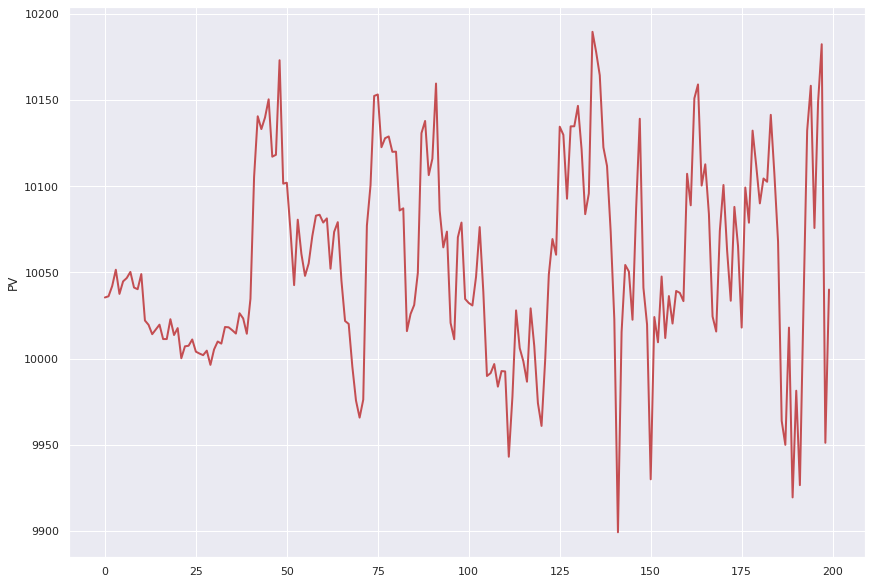

In [31]:
plot_train_pvs(name, ep_last_pvs)

In [32]:
states_buy, states_sell, total_gains, invest, pvs, invs = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 107.949997, total balance 9892.050003
day 1: buy 1 unit at price 108.059998, total balance 9783.990005
day 2, sell 1 unit at price 109.040001, investment 1.009730 %, total balance 9893.030006,
day 3: buy 1 unit at price 108.339996, total balance 9784.690010
day 4, sell 1 unit at price 108.500000, investment 0.407183 %, total balance 9893.190010,
day 6, sell 1 unit at price 110.250000, investment 1.762972 %, total balance 10003.440010,
day 10: buy 1 unit at price 112.989998, total balance 9890.450012
day 12: buy 1 unit at price 113.010002, total balance 9777.440010
day 13: buy 1 unit at price 114.330002, total balance 9663.110008
day 14: buy 1 unit at price 114.209999, total balance 9548.900009
day 16, sell 1 unit at price 115.699997, investment 2.398441 %, total balance 9664.600006,
day 18, sell 1 unit at price 116.199997, investment 2.822755 %, total balance 9780.800003,
day 20, sell 1 unit at price 115.669998, investment 1.172042 %, total balance 9896.47000

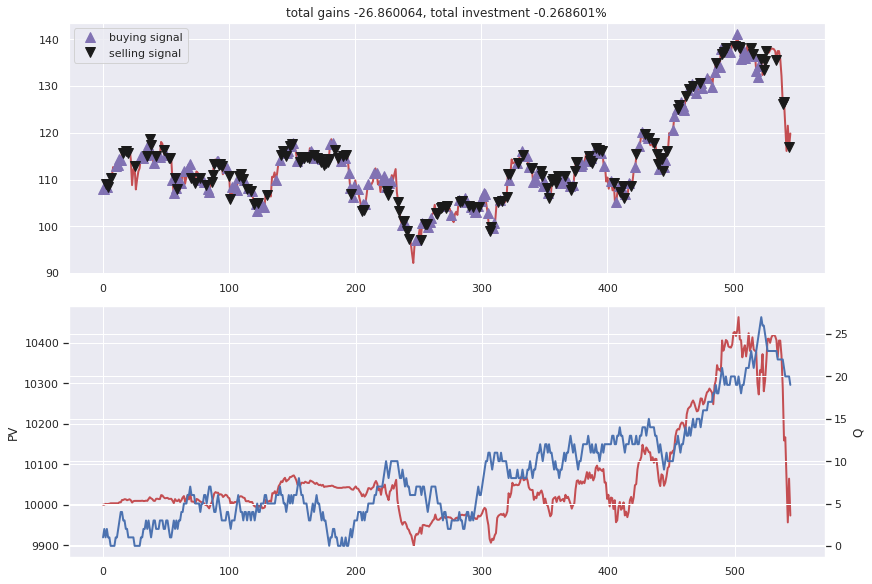

In [33]:
plot_price_pvs(name, df.Close, states_buy, states_sell, total_gains, invest, pvs, invs)

In [34]:
ep_last_pvs_1000 = agent.train(iterations = 1000, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 765.589919.3, cost: -18666.853516, balance: 2192.379895, total money: 10496.539824
epoch: 20, total rewards: 230.719945.3, cost: -32405.408203, balance: 8729.339956, total money: 10015.899945
epoch: 30, total rewards: 40.389925.3, cost: -33750.464844, balance: 10040.389925, total money: 10040.389925
epoch: 40, total rewards: 202.749916.3, cost: -32140.085938, balance: 7880.899941, total money: 9869.219924
epoch: 50, total rewards: 143.569927.3, cost: -33000.859375, balance: 9603.889949, total money: 10071.729945
epoch: 60, total rewards: 4.889978.3, cost: -33676.601562, balance: 10004.889978, total money: 10004.889978
epoch: 70, total rewards: 393.819927.3, cost: -30274.476562, balance: 7678.289958, total money: 10017.489938
epoch: 80, total rewards: -18.010030.3, cost: -33535.011719, balance: 9847.559977, total money: 9964.519976
epoch: 90, total rewards: 95.059921.3, cost: -33138.312500, balance: 9825.439926, total money: 10059.359924
epoch: 100, total rewar

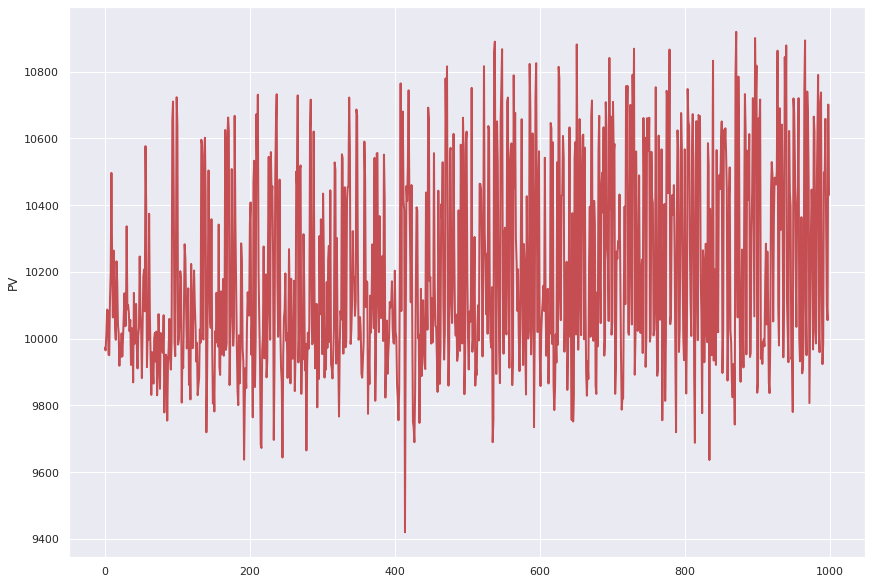

In [35]:
plot_train_pvs(name, ep_last_pvs_1000)

## Q-learning agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 274.710201.3, cost: 0.810730, total money: 10274.710201
epoch: 20, total rewards: 161.429929.3, cost: 0.406487, total money: 10161.429929
epoch: 30, total rewards: 89.659849.3, cost: 0.225568, total money: 10089.659849
epoch: 40, total rewards: 121.209836.3, cost: 0.152499, total money: 10121.209836
epoch: 50, total rewards: 94.869810.3, cost: 0.120762, total money: 10094.869810
epoch: 60, total rewards: 123.609922.3, cost: 0.097353, total money: 10123.609922
epoch: 70, total rewards: 130.149901.3, cost: 0.131718, total money: 10130.149901
epoch: 80, total rewards: 55.369871.3, cost: 0.072531, total money: 10055.369871
epoch: 90, total rewards: 177.780026.3, cost: 0.062346, total money: 10177.780026
epoch: 100, total rewards: 151.249997.3, cost: 0.056566, total money: 10151.249997
epoch: 110, total rewards: 101.629942.3, cost: 0.050717, total money: 10101.629942
epoch: 120, total rewards: 138.329892.3, cost: 0.075178, total money: 10138.329892
epoch: 130, tota

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 790.510010, total balance 9209.489990
day 5, sell 1 unit at price 785.309998, investment -0.657805 %, total balance 9994.799988,
day 14: buy 1 unit at price 768.270020, total balance 9226.529968
day 16, sell 1 unit at price 761.679993, investment -0.857775 %, total balance 9988.209961,
day 22: buy 1 unit at price 762.520020, total balance 9225.689941
day 23, sell 1 unit at price 759.109985, investment -0.447206 %, total balance 9984.799926,
day 28: buy 1 unit at price 796.099976, total balance 9188.699950
day 29, sell 1 unit at price 797.070007, investment 0.121848 %, total balance 9985.769957,
day 32: buy 1 unit at price 794.200012, total balance 9191.569945
day 35: buy 1 unit at price 791.260010, total balance 8400.309935
day 36: buy 1 unit at price 789.909973, total balance 7610.399962
day 37, sell 1 unit at price 791.549988, investment -0.333672 %, total balance 8401.949950,
day 38, sell 1 unit at price 785.049988, investment -0.784827 %, total balance 91

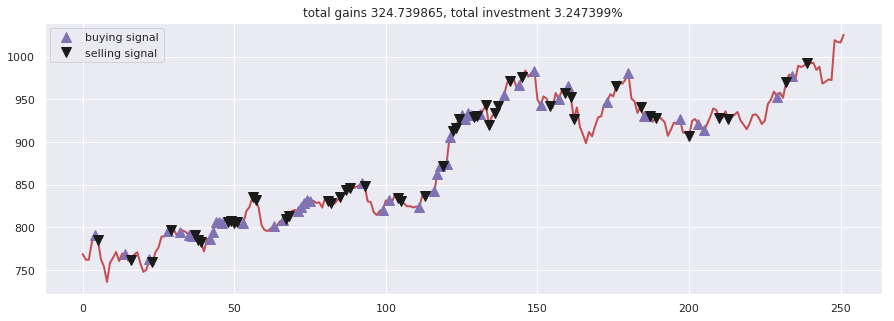

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Evolution Strategy agent

In [0]:
import pkg_resources
import types

df= df_full.copy()
name = 'Evolution Strategy agent'


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.9.0
pandas==0.23.4
numpy==1.14.5
matplotlib==3.0.2


In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [0]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 8.610248
iter 20. reward: 12.257399
iter 30. reward: 7.689600
iter 40. reward: 18.719300
iter 50. reward: 16.883897
iter 60. reward: 18.100399
iter 70. reward: 17.280399
iter 80. reward: 15.865947
iter 90. reward: 17.435298
iter 100. reward: 22.108749
iter 110. reward: 21.537897
iter 120. reward: 21.986898
iter 130. reward: 22.303096
iter 140. reward: 27.540547
iter 150. reward: 24.151497
iter 160. reward: 26.339196
iter 170. reward: 26.184596
iter 180. reward: 25.859546
iter 190. reward: 28.623797
iter 200. reward: 30.171547
iter 210. reward: 29.712899
iter 220. reward: 28.880399
iter 230. reward: 29.221448
iter 240. reward: 26.622551
iter 250. reward: 21.736548
iter 260. reward: 32.192049
iter 270. reward: 31.077749
iter 280. reward: 30.869947
iter 290. reward: 30.829648
iter 300. reward: 32.587899
iter 310. reward: 32.627998
iter 320. reward: 32.198498
iter 330. reward: 31.940298
iter 340. reward: 32.789998
iter 350. reward: 33.619697
iter 360. reward: 32.738196
ite

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 1: buy 1 unit at price 762.130005, total balance 9237.869995
day 3: buy 1 unit at price 782.520020, total balance 8455.349975
day 4, sell 1 unit at price 790.510010, investment 3.723775 %, total balance 9245.859985,
day 5, sell 1 unit at price 785.309998, investment 0.356538 %, total balance 10031.169983,
day 6: buy 1 unit at price 762.559998, total balance 9268.609985
day 10: buy 1 unit at price 764.479980, total balance 8504.130005
day 11: buy 1 unit at price 771.229980, total balance 7732.900025
day 12: buy 1 unit at price 760.539978, total balance 6972.360047
day 17: buy 1 unit at price 768.239990, total balance 6204.120057
day 18: buy 1 unit at price 770.840027, total balance 5433.280030
day 19: buy 1 unit at price 758.039978, total balance 4675.240052
day 20: buy 1 unit at price 747.919983, total balance 3927.320069
day 21: buy 1 unit at price 750.500000, total balance 3176.820069
day 24, sell 1 unit at price 771.190002, investment 1.131715 %, total balance 3948.010071,
day 2

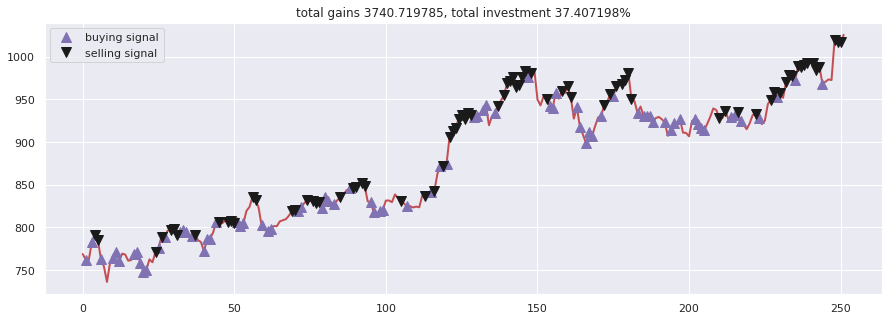

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Double Q-learning agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Double Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1241.885127.3, cost: 1.110860, total money: 1744.875178
epoch: 20, total rewards: 89.105106.3, cost: 0.649060, total money: 8097.275088
epoch: 30, total rewards: 719.079470.3, cost: 0.823131, total money: 9699.809450
epoch: 40, total rewards: 684.040043.3, cost: 1.931746, total money: 134.750004
epoch: 50, total rewards: 1744.829771.3, cost: 0.895153, total money: 11744.829771
epoch: 60, total rewards: 149.195010.3, cost: 1.097174, total money: 5196.854982
epoch: 70, total rewards: 1389.289786.3, cost: 0.860031, total money: 9399.319754
epoch: 80, total rewards: 529.019898.3, cost: 0.305593, total money: 10529.019898
epoch: 90, total rewards: 1285.264893.3, cost: 1.882383, total money: 9251.514893
epoch: 100, total rewards: 409.474970.3, cost: 0.146280, total money: 551.414972
epoch: 110, total rewards: 1074.725155.3, cost: 0.661549, total money: 2231.475154
epoch: 120, total rewards: 1713.854676.3, cost: 1.219318, total money: 11713.854676
epoch: 130, total r

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 7: buy 1 unit at price 754.020020, total balance 9245.979980
day 9, sell 1 unit at price 758.489990, investment 0.592818 %, total balance 10004.469970,
day 10: buy 1 unit at price 764.479980, total balance 9239.989990
day 11: buy 1 unit at price 771.229980, total balance 8468.760010
day 12, sell 1 unit at price 760.539978, investment -0.515383 %, total balance 9229.299988,
day 13, sell 1 unit at price 769.200012, investment -0.263212 %, total balance 9998.500000,
day 17: buy 1 unit at price 768.239990, total balance 9230.260010
day 19, sell 1 unit at price 758.039978, investment -1.327712 %, total balance 9988.299988,
day 21: buy 1 unit at price 750.500000, total balance 9237.799988
day 22, sell 1 unit at price 762.520020, investment 1.601602 %, total balance 10000.320008,
day 26: buy 1 unit at price 789.289978, total balance 9211.030030
day 27, sell 1 unit at price 789.270020, investment -0.002529 %, total balance 10000.300050,
day 30: buy 1 unit at price 797.849976, total balance

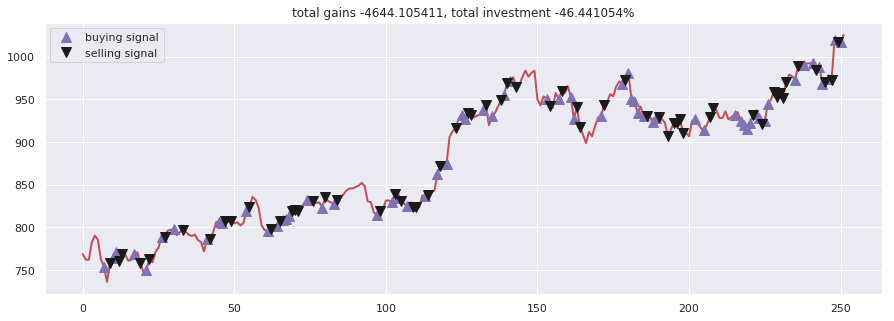

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Recurrent Q-learning agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Recurrent Q-learning agent'
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.X = tf.placeholder(tf.float32, (None, None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, self.OUTPUT_SIZE))
        cell = tf.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
        self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * self.LAYER_SIZE))
        self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
        self.logits = tf.layers.dense(self.rnn[:,-1], self.OUTPUT_SIZE)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.logits, feed_dict={self.X:states, self.hidden_layer:init_values})
        Q_new = self.sess.run(self.logits, feed_dict={self.X:new_states, self.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * np.amax(Q_new[i])
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            action, last_state = self.sess.run([self.logits,self.last_state],
                                                feed_dict={self.X:[self.INITIAL_FEATURES],
                                                            self.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.logits,
                                                  self.last_state],
                                                  feed_dict={self.X:[self.INITIAL_FEATURES],
                                                             self.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.cost, self.optimizer], 
                                        feed_dict={self.X: X, self.Y:Y,
                                                  self.hidden_layer: INIT_VAL})
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
                
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 449.400388.3, cost: 0.117951, total money: 7420.680355
epoch: 20, total rewards: 513.109983.3, cost: 0.187314, total money: 7552.130003
epoch: 30, total rewards: 1755.114813.3, cost: 0.337607, total money: 6759.834784
epoch: 40, total rewards: 545.719909.3, cost: 0.555657, total money: 9529.079894
epoch: 50, total rewards: 593.435182.3, cost: 0.399239, total money: 6611.165162
epoch: 60, total rewards: 285.174678.3, cost: 0.071772, total money: 6314.564631
epoch: 70, total rewards: 169.200014.3, cost: 0.796504, total money: 4264.030030
epoch: 80, total rewards: 520.019840.3, cost: 0.567794, total money: 6501.959842
epoch: 90, total rewards: 498.320189.3, cost: 0.245750, total money: 9481.210204
epoch: 100, total rewards: 1572.605044.3, cost: 1.142984, total money: 11572.605044
epoch: 110, total rewards: 297.584960.3, cost: 0.973414, total money: 10297.584960
epoch: 120, total rewards: 912.394901.3, cost: 2.032860, total money: 6987.034854
epoch: 130, total rew

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 13: buy 1 unit at price 769.200012, total balance 9230.799988
day 14: buy 1 unit at price 768.270020, total balance 8462.529968
day 15, sell 1 unit at price 760.989990, investment -1.067346 %, total balance 9223.519958,
day 17: buy 1 unit at price 768.239990, total balance 8455.279968
day 18, sell 1 unit at price 770.840027, investment 0.334519 %, total balance 9226.119995,
day 19, sell 1 unit at price 758.039978, investment -1.327712 %, total balance 9984.159973,
day 29: buy 1 unit at price 797.070007, total balance 9187.089966
day 30: buy 1 unit at price 797.849976, total balance 8389.239990
day 33, sell 1 unit at price 796.419983, investment -0.081552 %, total balance 9185.659973,
day 34: buy 1 unit at price 794.559998, total balance 8391.099975
day 36, sell 1 unit at price 789.909973, investment -0.995175 %, total balance 9181.009948,
day 37, sell 1 unit at price 791.549988, investment -0.378827 %, total balance 9972.559936,
day 39: buy 1 unit at price 782.789978, total balance

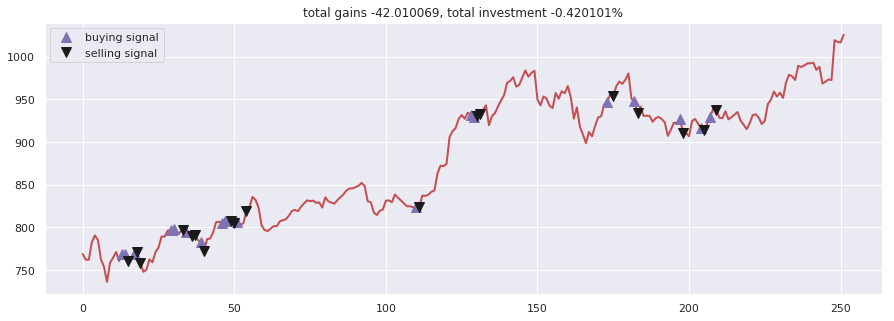

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Double Recurrent Q-learning agent

In [0]:
from collections import deque
import random


df= df_full.copy()
name = 'Double Recurrent Q-learning agent'


class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate, name):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            cell = tf.nn.rnn_cell.LSTMCell(layer_size, state_is_tuple = False)
            self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * layer_size))
            self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            self.logits = tf.layers.dense(self.rnn[:,-1], output_size)
            self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                           'real_model')
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                                   'negative_model')
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.model.logits, feed_dict={self.model.X:states, 
                                                   self.model.hidden_layer:init_values})
        Q_new = self.sess.run(self.model.logits, feed_dict={self.model.X:new_states, 
                                                       self.model.hidden_layer:init_values})
        Q_new_negative = self.sess.run(self.model_negative.logits, 
                                  feed_dict={self.model_negative.X:new_states, 
                                             self.model_negative.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            action, last_state = self.sess.run([self.model.logits,self.model.last_state],
                                                feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                            self.model.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
            
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('real_model', 'negative_model')
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.model.logits,
                                                  self.model.last_state],
                                                  feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                             self.model.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y,
                                                  self.model.hidden_layer: INIT_VAL})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1305.274912.3, cost: 0.402263, total money: 777.284860
epoch: 20, total rewards: 582.070375.3, cost: 0.782595, total money: 804.650331
epoch: 30, total rewards: 420.380369.3, cost: 1.481925, total money: 80.210326
epoch: 40, total rewards: 1502.554748.3, cost: 0.343374, total money: 2823.564757
epoch: 50, total rewards: 589.170222.3, cost: 0.370314, total money: 6597.640193
epoch: 60, total rewards: 1069.864985.3, cost: 0.733583, total money: 10052.755000
epoch: 70, total rewards: 900.360168.3, cost: 0.154633, total money: 8866.610168
epoch: 80, total rewards: 625.559509.3, cost: 0.573019, total money: 9652.999511
epoch: 90, total rewards: 966.905028.3, cost: 0.080430, total money: 6971.785033
epoch: 100, total rewards: 784.169802.3, cost: 0.568819, total money: 10784.169802
epoch: 110, total rewards: 658.149963.3, cost: 0.052230, total money: 9641.509948
epoch: 120, total rewards: 615.210201.3, cost: 0.802322, total money: 9595.940181
epoch: 130, total reward

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1, sell 1 unit at price 762.130005, investment -0.854691 %, total balance 9993.429993,
day 3: buy 1 unit at price 782.520020, total balance 9210.909973
day 4, sell 1 unit at price 790.510010, investment 1.021059 %, total balance 10001.419983,
day 5: buy 1 unit at price 785.309998, total balance 9216.109985
day 6, sell 1 unit at price 762.559998, investment -2.896945 %, total balance 9978.669983,
day 7: buy 1 unit at price 754.020020, total balance 9224.649963
day 8, sell 1 unit at price 736.080017, investment -2.379248 %, total balance 9960.729980,
day 13: buy 1 unit at price 769.200012, total balance 9191.529968
day 16, sell 1 unit at price 761.679993, investment -0.977642 %, total balance 9953.209961,
day 19: buy 1 unit at price 758.039978, total balance 9195.169983
day 20, sell 1 unit at price 747.919983, investment -1.335021 %, total balance 9943.089966,
day 24: buy 1 unit at price 771.190002, total balance 9171.8

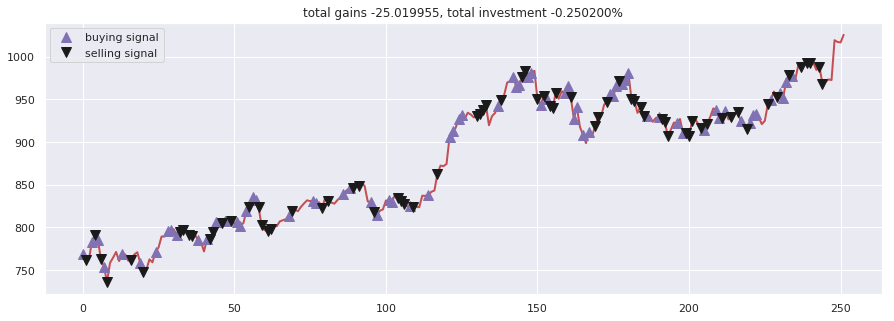

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Duel Q-learning agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Duel Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 512, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, self.action_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch: 10, total rewards: 231.100222.3, cost: 0.499693, total money: 10231.100222
epoch: 20, total rewards: 195.875063.3, cost: 0.324152, total money: 10195.875063
epoch: 30, total rewards: 219.615054.3, cost: 0.237771, total money: 10219.615054
epoch: 40, total rewards: 56.505131.3, cost: 0.183305, total money: 10056.505131
epoch: 50, total rewards: 190.745120.3, cost: 0.129967, total money: 10190.745120
epoch: 60, total rewards: 165.275088.3, cost: 0.134246, total money: 10165.275088
epoch: 70, total rewards: 201.795107.3, cost: 0.075016, total money: 10201.795107
epoch: 80, total rewards: 187.545045.3, cost: 0.062454, total money: 10187.545045
epoch: 90, total rewards: 206.835023.3, cost: 0.050687, total money: 10206.835023
epoch: 100, total rewards: 199.895082.3, cost: 0.041359, total money: 10199.895082
epoch: 110, total rewards: 184.405092.3, cost: 0.035289, total money: 10184.405092
epoch: 120, total reward

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 7: buy 1 unit at price 754.020020, total balance 9245.979980
day 8: buy 1 unit at price 736.080017, total balance 8509.899963
day 9, sell 1 unit at price 758.489990, investment 0.592818 %, total balance 9268.389953,
day 11: buy 1 unit at price 771.229980, total balance 8497.159973
day 12, sell 1 unit at price 760.539978, investment 3.323003 %, total balance 9257.699951,
day 14, sell 1 unit at price 768.270020, investment -0.383797 %, total balance 10025.969971,
day 22: buy 1 unit at price 762.520020, total balance 9263.449951
day 24, sell 1 unit at price 771.190002, investment 1.137017 %, total balance 10034.639953,
day 28: buy 1 unit at price 796.099976, total balance 9238.539977
day 29: buy 1 unit at price 797.070007, total balance 8441.469970
day 31, sell 1 unit at price 790.799988, investment -0.665744 %, total balance 9232.269958,
day 32: buy 1 unit at price 794.200012, total balance 8438.069946
day 33: buy 1 unit at price 796.419983, total balance 7641.649963
day 37, sell 1 u

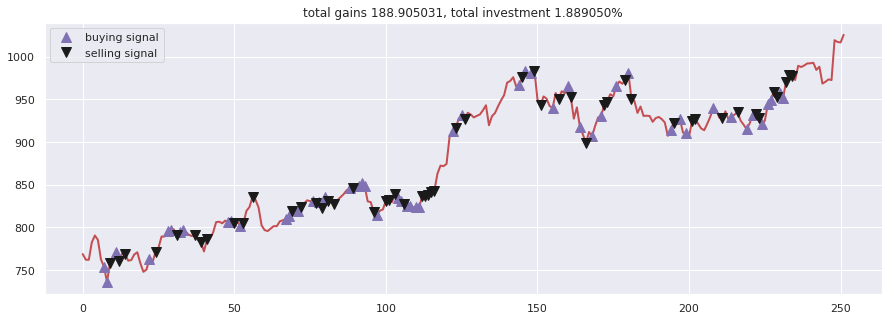

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Double Duel Q-learning agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Double Duel Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, output_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch: 10, total rewards: 1486.684997.3, cost: 0.694152, total money: 10514.124999
epoch: 20, total rewards: 313.279660.3, cost: 0.878157, total money: 8354.909665
epoch: 30, total rewards: 752.595089.3, cost: 0.320037, total money: 10752.595089
epoch: 40, total rewards: 1159.299987.3, cost: 0.318166, total money: 10186.739989
epoch: 50, total rewards: 993.220279.3, cost: 0.391151, total money: 4149.310245
epoch: 60, total rewards: 1616.499880.3, cost: 0.307440, total money: 9630.939883
epoch: 70, total rewards: 941.484560.3, cost: 0.332979, total money: 6969.054506
epoch: 80, total rewards: 904.899903.3, cost: 0.718111, total money: 1132.559876
epoch: 90, total rewards: 346.619873.3, cost: 0.482044, total money: 542.599852
epoch: 100, total rewards: 141.554626.3, cost: 0.238426, total money: 6115.974608
epoch: 110, total rewards: -159.529845.3, cost: 0.202412, total money: 8852.270143
epoch: 120, total rewards: -

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 762.130005, total balance 9237.869995
day 2, sell 1 unit at price 762.020020, investment -0.014431 %, total balance 9999.890015,
day 11: buy 1 unit at price 771.229980, total balance 9228.660035
day 12: buy 1 unit at price 760.539978, total balance 8468.120057
day 13, sell 1 unit at price 769.200012, investment -0.263212 %, total balance 9237.320069,
day 15, sell 1 unit at price 760.989990, investment 0.059170 %, total balance 9998.310059,
day 34: buy 1 unit at price 794.559998, total balance 9203.750061
day 35, sell 1 unit at price 791.260010, investment -0.415323 %, total balance 9995.010071,
day 36: buy 1 unit at price 789.909973, total balance 9205.100098
day 37, sell 1 unit at price 791.549988, investment 0.207620 %, total balance 9996.650086,
day 38: buy 1 unit at price 785.049988, total balance 9211.600098
day 40, sell 1 unit at price 771.820007, investment -1.685241 %, total balance 9983.420105,
day 54: buy 1 unit at price 819.309998, total balance 91

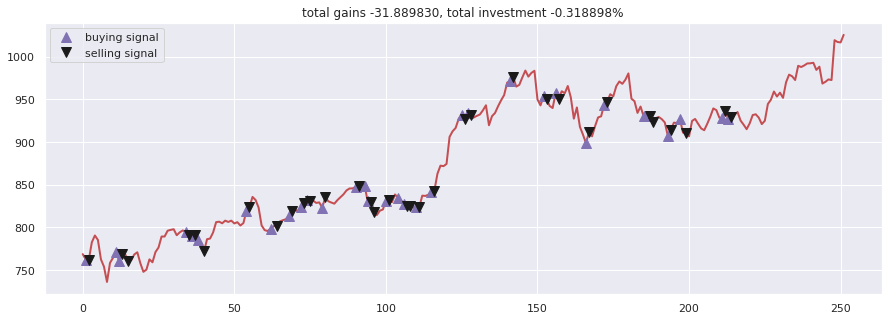

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Duel Recurrent Q-learning agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Duel Recurrent Q-learning agent'
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.X = tf.placeholder(tf.float32, (None, None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, self.OUTPUT_SIZE))
        cell = tf.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
        self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * self.LAYER_SIZE))
        self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
        tensor_action, tensor_validation = tf.split(self.rnn[:,-1],2,1)
        feed_action = tf.layers.dense(tensor_action, self.OUTPUT_SIZE)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.logits, feed_dict={self.X:states, self.hidden_layer:init_values})
        Q_new = self.sess.run(self.logits, feed_dict={self.X:new_states, self.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * np.amax(Q_new[i])
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            action, last_state = self.sess.run([self.logits,self.last_state],
                                                feed_dict={self.X:[self.INITIAL_FEATURES],
                                                            self.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.logits,
                                                  self.last_state],
                                                  feed_dict={self.X:[self.INITIAL_FEATURES],
                                                             self.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.cost, self.optimizer], 
                                        feed_dict={self.X: X, self.Y:Y,
                                                  self.hidden_layer: INIT_VAL})
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
                
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch: 10, total rewards: 1303.755127.3, cost: 0.204159, total money: 2622.175109
epoch: 20, total rewards: 1332.510133.3, cost: 2.512769, total money: 11332.510133
epoch: 30, total rewards: 167.034789.3, cost: 0.204751, total money: 10167.034789
epoch: 40, total rewards: 885.269897.3, cost: 0.095390, total money: 8848.889892
epoch: 50, total rewards: 312.624996.3, cost: 0.415782, total money: 10312.624996
epoch: 60, total rewards: 220.209960.3, cost: 0.119438, total money: 10220.209960
epoch: 70, total rewards: 407.794859.3, cost: 0.983801, total money: 8417.984861
epoch: 80, total rewards: 200.149718.3, cost: 0.235913, total money: 9226.819701
epoch: 90, total rewards: 87.564821.3, cost: 0.034903, total money: 8097.894838
epoch: 100, total rewards: 1056.600041.3, cost: 0.286240, total money: 11056.600041
epoch: 110, total rewards: 537.204957.3, cost: 0.140037, total money: 7610.014955
epoch: 120, total rewards: 

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 53: buy 1 unit at price 805.020020, total balance 9194.979980
day 54, sell 1 unit at price 819.309998, investment 1.775108 %, total balance 10014.289978,
day 64: buy 1 unit at price 801.340027, total balance 9212.949951
day 68, sell 1 unit at price 813.669983, investment 1.538667 %, total balance 10026.619934,
day 79: buy 1 unit at price 823.210022, total balance 9203.409912
day 82: buy 1 unit at price 829.080017, total balance 8374.329895
day 84, sell 1 unit at price 831.909973, investment 1.056832 %, total balance 9206.239868,
day 86, sell 1 unit at price 838.679993, investment 1.157907 %, total balance 10044.919861,
day 111: buy 1 unit at price 823.559998, total balance 9221.359863
day 116, sell 1 unit at price 843.190002, investment 2.383555 %, total balance 10064.549865,
day 167: buy 1 unit at price 911.710022, total balance 9152.839843
day 169, sell 1 unit at price 918.590027, investment 0.754626 %, total balance 10071.429870,
day 182: buy 1 unit at price 947.799988, total ba

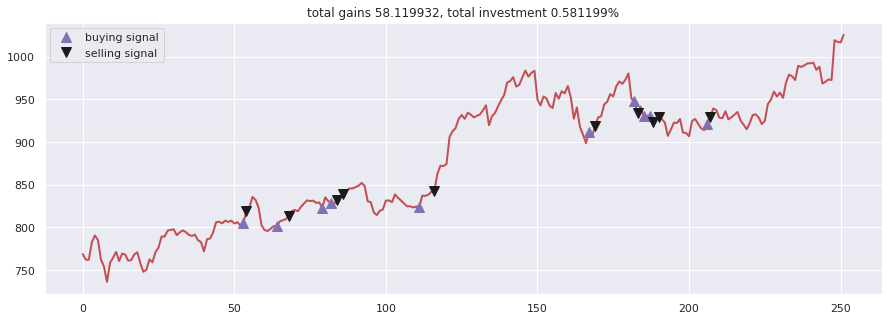

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Double Duel Recurrent Q-learning agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Double Duel Recurrent Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate, name):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            cell = tf.nn.rnn_cell.LSTMCell(layer_size, state_is_tuple = False)
            self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * layer_size))
            self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            tensor_action, tensor_validation = tf.split(self.rnn[:,-1],2,1)
            feed_action = tf.layers.dense(tensor_action, output_size)
            feed_validation = tf.layers.dense(tensor_validation, 1)
            self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
            self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                           'real_model')
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                                   'negative_model')
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.model.logits, feed_dict={self.model.X:states, 
                                                   self.model.hidden_layer:init_values})
        Q_new = self.sess.run(self.model.logits, feed_dict={self.model.X:new_states, 
                                                       self.model.hidden_layer:init_values})
        Q_new_negative = self.sess.run(self.model_negative.logits, 
                                  feed_dict={self.model_negative.X:new_states, 
                                             self.model_negative.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            action, last_state = self.sess.run([self.model.logits,self.model.last_state],
                                                feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                            self.model.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('real_model', 'negative_model')
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.model.logits,
                                                  self.model.last_state],
                                                  feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                             self.model.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y,
                                                  self.model.hidden_layer: INIT_VAL})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch: 10, total rewards: 328.014401.3, cost: 0.233912, total money: 2446.714413
epoch: 20, total rewards: 629.485052.3, cost: 0.592428, total money: 5723.605047
epoch: 30, total rewards: 1222.065245.3, cost: 0.182284, total money: 7288.965209
epoch: 40, total rewards: 719.309753.3, cost: 0.690094, total money: 3739.159728
epoch: 50, total rewards: 328.994876.3, cost: 0.918951, total money: 2756.724856
epoch: 60, total rewards: 1518.540281.3, cost: 0.226017, total money: 10545.210264
epoch: 70, total rewards: 440.315127.3, cost: 0.145386, total money: 7494.335086
epoch: 80, total rewards: 656.779966.3, cost: 0.113699, total money: 6666.949948
epoch: 90, total rewards: 846.820129.3, cost: 0.444679, total money: 6860.080139
epoch: 100, total rewards: 1044.679930.3, cost: 0.240218, total money: 9067.419920
epoch: 110, total rewards: 207.934935.3, cost: 0.236219, total money: 10207.934935
epoch: 120, total rewards: 6.

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 17: buy 1 unit at price 768.239990, total balance 9231.760010
day 18, sell 1 unit at price 770.840027, investment 0.338441 %, total balance 10002.600037,
day 20: buy 1 unit at price 747.919983, total balance 9254.680054
day 21: buy 1 unit at price 750.500000, total balance 8504.180054
day 23, sell 1 unit at price 759.109985, investment 1.496150 %, total balance 9263.290039,
day 24, sell 1 unit at price 771.190002, investment 2.756829 %, total balance 10034.480041,
day 27: buy 1 unit at price 789.270020, total balance 9245.210021
day 28, sell 1 unit at price 796.099976, investment 0.865351 %, total balance 10041.309997,
day 34: buy 1 unit at price 794.559998, total balance 9246.749999
day 35, sell 1 unit at price 791.260010, investment -0.415323 %, total balance 10038.010009,
day 36: buy 1 unit at price 789.909973, total balance 9248.100036
day 38: buy 1 unit at price 785.049988, total balance 8463.050048
day 40: buy 1 unit at price 771.820007, total balance 7691.230041
day 41, sell

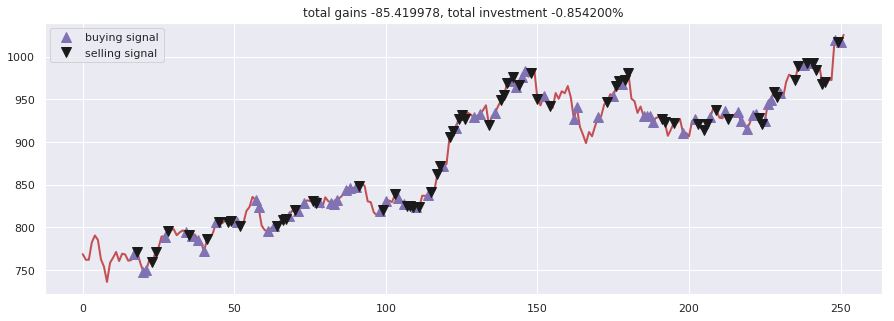

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

# 3 Acto-critic

## Actor-critic agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Actor-critic agent'

class Actor:
    def __init__(self, name, input_size, output_size, size_layer):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            feed_actor = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_actor, output_size)

class Critic:
    def __init__(self, name, input_size, output_size, size_layer, learning_rate):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            self.REWARD = tf.placeholder(tf.float32, (None, 1))
            feed_critic = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            feed_critic = tf.layers.dense(feed_critic, output_size, activation = tf.nn.relu) + self.Y
            feed_critic = tf.layers.dense(feed_critic, size_layer//2, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_critic, 1)
            self.cost = tf.reduce_mean(tf.square(self.REWARD - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
            
class Agent:

    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    COPY = 1000
    T_COPY = 0

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.actor = Actor('actor-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.actor_target = Actor('actor-target', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.critic = Critic('critic-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.critic_target = Critic('critic-target', self.state_size, self.OUTPUT_SIZE, 
                                    self.LAYER_SIZE, self.LEARNING_RATE)
        self.grad_critic = tf.gradients(self.critic.logits, self.critic.Y)
        self.actor_critic_grad = tf.placeholder(tf.float32, [None, self.OUTPUT_SIZE])
        weights_actor = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='actor')
        self.grad_actor = tf.gradients(self.actor.logits, weights_actor, -self.actor_critic_grad)
        grads = zip(self.grad_actor, weights_actor)
        self.optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).apply_gradients(grads)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)
            
    def _memorize(self, state, action, reward, new_state, dead):
        self.MEMORIES.append((state, action, reward, new_state, dead))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            prediction = self.sess.run(self.actor.logits, feed_dict={self.actor.X:[state]})[0]
            action = np.argmax(prediction)
        return action
    
    def _construct_memories_and_train(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.sess.run(self.actor.logits, feed_dict={self.actor.X: states})
        Q_target = self.sess.run(self.actor_target.logits, feed_dict={self.actor_target.X: states})
        grads = self.sess.run(self.grad_critic, feed_dict={self.critic.X:states, self.critic.Y:Q})[0]
        self.sess.run(self.optimizer, feed_dict={self.actor.X:states, self.actor_critic_grad:grads})
        
        rewards = np.array([a[2] for a in replay]).reshape((-1, 1))
        rewards_target = self.sess.run(self.critic_target.logits, 
                                       feed_dict={self.critic_target.X:new_states,self.critic_target.Y:Q_target})
        for i in range(len(replay)):
            if not replay[0][-1]:
                rewards[i] += self.GAMMA * rewards_target[i]
        cost, _ = self.sess.run([self.critic.cost, self.critic.optimizer], 
                                feed_dict={self.critic.X:states, self.critic.Y:Q, self.critic.REWARD:rewards})
        return cost
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('actor-original', 'actor-target')
                    self._assign('critic-original', 'critic-target')
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                state = next_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories_and_train(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1539.185237.3, cost: 2.181347, total money: 1684.395196
epoch: 20, total rewards: 1308.335026.3, cost: 658.992737, total money: 11308.335026
epoch: 30, total rewards: 810.315002.3, cost: 19406.357422, total money: 5871.594971
epoch: 40, total rewards: 380.889899.3, cost: 436790400.000000, total money: 7327.869879
epoch: 50, total rewards: 676.170224.3, cost: 27570524160.000000, total money: 10676.170224
epoch: 60, total rewards: 796.770199.3, cost: 935274741760.000000, total money: 10796.770199
epoch: 70, total rewards: 47.440366.3, cost: 8344191369216.000000, total money: 7043.150388
epoch: 80, total rewards: 450.169980.3, cost: 88121093914624.000000, total money: 6472.479916
epoch: 90, total rewards: 443.664980.3, cost: 675454474256384.000000, total money: 9427.024965
epoch: 100, total rewards: 350.460142.3, cost: 1153362061950976.000000, total money: 10350.460142
epoch: 110, total rewards: 247.584961.3, cost: 6317238688677888.000000, total money: 9230.94494

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 782.520020, total balance 9217.479980
day 4: buy 1 unit at price 790.510010, total balance 8426.969970
day 5, sell 1 unit at price 785.309998, investment 0.356538 %, total balance 9212.279968,
day 6, sell 1 unit at price 762.559998, investment -3.535694 %, total balance 9974.839966,
day 16: buy 1 unit at price 761.679993, total balance 9213.159973
day 17: buy 1 unit at price 768.239990, total balance 8444.919983
day 18, sell 1 unit at price 770.840027, investment 1.202609 %, total balance 9215.760010,
day 19, sell 1 unit at price 758.039978, investment -1.327712 %, total balance 9973.799988,
day 20: buy 1 unit at price 747.919983, total balance 9225.880005
day 21: buy 1 unit at price 750.500000, total balance 8475.380005
day 22, sell 1 unit at price 762.520020, investment 1.952085 %, total balance 9237.900025,
day 24, sell 1 unit at price 771.190002, investment 2.756829 %, total balance 10009.090027,
day 25: buy 1 unit at price 776.419983, total balance 9232.

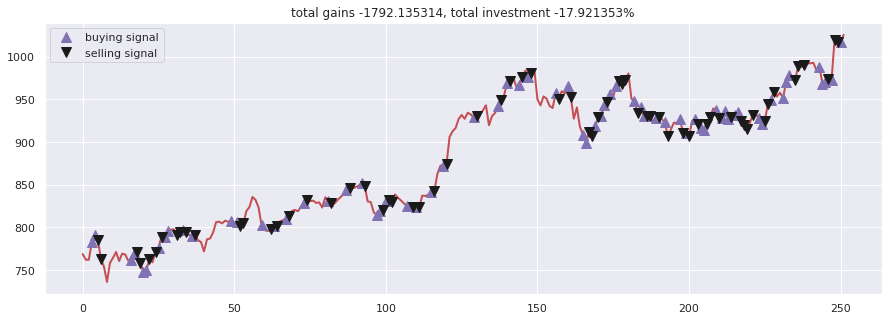

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Actor-critic Duel agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Actor-critic Duel agent'

class Actor:
    def __init__(self, name, input_size, output_size, size_layer):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            feed_actor = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            tensor_action, tensor_validation = tf.split(feed_actor,2,1)
            feed_action = tf.layers.dense(tensor_action, output_size)
            feed_validation = tf.layers.dense(tensor_validation, 1)
            self.logits = feed_validation + tf.subtract(feed_action,
                                                        tf.reduce_mean(feed_action,axis=1,keep_dims=True))

class Critic:
    def __init__(self, name, input_size, output_size, size_layer, learning_rate):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            self.REWARD = tf.placeholder(tf.float32, (None, 1))
            feed_critic = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            tensor_action, tensor_validation = tf.split(feed_critic,2,1)
            feed_action = tf.layers.dense(tensor_action, output_size)
            feed_validation = tf.layers.dense(tensor_validation, 1)
            feed_critic = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
            feed_critic = tf.nn.relu(feed_critic) + self.Y
            feed_critic = tf.layers.dense(feed_critic, size_layer//2, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_critic, 1)
            self.cost = tf.reduce_mean(tf.square(self.REWARD - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
            
class Agent:

    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    COPY = 1000
    T_COPY = 0

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.actor = Actor('actor-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.actor_target = Actor('actor-target', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.critic = Critic('critic-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.critic_target = Critic('critic-target', self.state_size, self.OUTPUT_SIZE, 
                                    self.LAYER_SIZE, self.LEARNING_RATE)
        self.grad_critic = tf.gradients(self.critic.logits, self.critic.Y)
        self.actor_critic_grad = tf.placeholder(tf.float32, [None, self.OUTPUT_SIZE])
        weights_actor = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='actor')
        self.grad_actor = tf.gradients(self.actor.logits, weights_actor, -self.actor_critic_grad)
        grads = zip(self.grad_actor, weights_actor)
        self.optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).apply_gradients(grads)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)
            
    def _memorize(self, state, action, reward, new_state, dead):
        self.MEMORIES.append((state, action, reward, new_state, dead))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            prediction = self.sess.run(self.actor.logits, feed_dict={self.actor.X:[state]})[0]
            action = np.argmax(prediction)
        return action
    
    def _construct_memories_and_train(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.sess.run(self.actor.logits, feed_dict={self.actor.X: states})
        Q_target = self.sess.run(self.actor_target.logits, feed_dict={self.actor_target.X: states})
        grads = self.sess.run(self.grad_critic, feed_dict={self.critic.X:states, self.critic.Y:Q})[0]
        self.sess.run(self.optimizer, feed_dict={self.actor.X:states, self.actor_critic_grad:grads})
        
        rewards = np.array([a[2] for a in replay]).reshape((-1, 1))
        rewards_target = self.sess.run(self.critic_target.logits, 
                                       feed_dict={self.critic_target.X:new_states,self.critic_target.Y:Q_target})
        for i in range(len(replay)):
            if not replay[0][-1]:
                rewards[i] += self.GAMMA * rewards_target[i]
        cost, _ = self.sess.run([self.critic.cost, self.critic.optimizer], 
                                feed_dict={self.critic.X:states, self.critic.Y:Q, self.critic.REWARD:rewards})
        return cost
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('actor-original', 'actor-target')
                    self._assign('critic-original', 'critic-target')
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories_and_train(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch: 10, total rewards: 707.200200.3, cost: 0.405626, total money: 9715.020207
epoch: 20, total rewards: 1598.640143.3, cost: 30.734631, total money: 10581.530158
epoch: 30, total rewards: 1271.279733.3, cost: 465.966644, total money: 10254.169748
epoch: 40, total rewards: 611.054993.3, cost: 38.079464, total money: 2818.014953
epoch: 50, total rewards: 1098.115172.3, cost: 71481.406250, total money: 1453.295102
epoch: 60, total rewards: 575.370237.3, cost: 45955692.000000, total money: 9558.260252
epoch: 70, total rewards: 1020.545110.3, cost: 244974075904.000000, total money: 10003.435125
epoch: 80, total rewards: 824.555359.3, cost: 62751015698432.000000, total money: 4025.125366
epoch: 90, total rewards: 182.215205.3, cost: 3949580517376.000000, total money: 10182.215205
epoch: 100, total rewards: 861.215276.3, cost: 7310792458240.000000, total money: 7918.025274
epoch: 110, total rewards: 68.690005.3, cost:

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 2: buy 1 unit at price 762.020020, total balance 8469.279968
day 3, sell 1 unit at price 782.520020, investment 1.797842 %, total balance 9251.799988,
day 4, sell 1 unit at price 790.510010, investment 3.738746 %, total balance 10042.309998,
day 5: buy 1 unit at price 785.309998, total balance 9257.000000
day 8: buy 1 unit at price 736.080017, total balance 8520.919983
day 11, sell 1 unit at price 771.229980, investment -1.792925 %, total balance 9292.149963,
day 12: buy 1 unit at price 760.539978, total balance 8531.609985
day 14: buy 1 unit at price 768.270020, total balance 7763.339965
day 15: buy 1 unit at price 760.989990, total balance 7002.349975
day 17, sell 1 unit at price 768.239990, investment 4.369087 %, total balance 7770.589965,
day 20, sell 1 unit at price 747.919983, investment -1.659347 %, total balance 8518.509948,
day 21, sell 1 unit at price 750.500000, investment -2.312991 %, total balance 9269.00

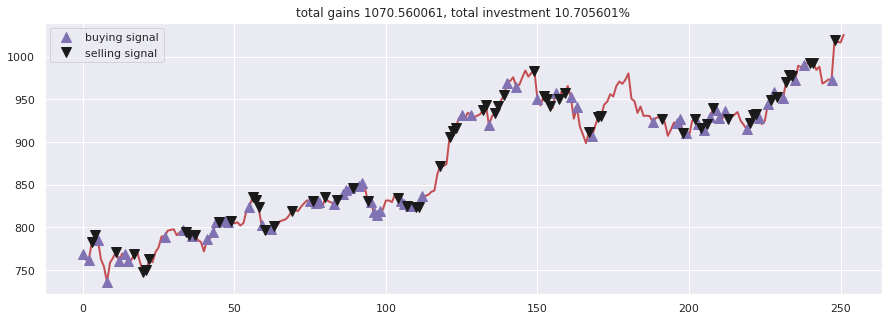

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Actor-critic Recurrent agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Actor-critic Recurrent agent'

class Actor:
    def __init__(self, name, input_size, output_size, size_layer):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, None, input_size))
            self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * size_layer))
            cell = tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
            self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X, cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            self.logits = tf.layers.dense(self.rnn[:,-1], output_size)

class Critic:
    def __init__(self, name, input_size, output_size, size_layer, learning_rate):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * size_layer))
            self.REWARD = tf.placeholder(tf.float32, (None, 1))
            feed_critic = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            cell = tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
            self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X, cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            feed_critic = tf.layers.dense(self.rnn[:,-1], output_size, activation = tf.nn.relu) + self.Y
            feed_critic = tf.layers.dense(feed_critic, size_layer//2, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_critic, 1)
            self.cost = tf.reduce_mean(tf.square(self.REWARD - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
            
class Agent:

    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    COPY = 1000
    T_COPY = 0

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.skip = skip
        tf.reset_default_graph()
        self.actor = Actor('actor-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.actor_target = Actor('actor-target', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.critic = Critic('critic-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.critic_target = Critic('critic-target', self.state_size, self.OUTPUT_SIZE, 
                                    self.LAYER_SIZE, self.LEARNING_RATE)
        self.grad_critic = tf.gradients(self.critic.logits, self.critic.Y)
        self.actor_critic_grad = tf.placeholder(tf.float32, [None, self.OUTPUT_SIZE])
        weights_actor = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='actor')
        self.grad_actor = tf.gradients(self.actor.logits, weights_actor, -self.actor_critic_grad)
        grads = zip(self.grad_actor, weights_actor)
        self.optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).apply_gradients(grads)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)
            
    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            prediction = self.sess.run(self.actor.logits, feed_dict={self.actor.X:[state]})[0]
            action = np.argmax(prediction)
        return action
    
    def _construct_memories_and_train(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.actor.logits, feed_dict={self.actor.X: states,
                                                       self.actor.hidden_layer: init_values})
        Q_target = self.sess.run(self.actor_target.logits, feed_dict={self.actor_target.X: states,
                                                                     self.actor_target.hidden_layer: init_values})
        grads = self.sess.run(self.grad_critic, feed_dict={self.critic.X:states, self.critic.Y:Q,
                                                          self.critic.hidden_layer: init_values})[0]
        self.sess.run(self.optimizer, feed_dict={self.actor.X:states, self.actor_critic_grad:grads,
                                                self.actor.hidden_layer: init_values})
        
        rewards = np.array([a[2] for a in replay]).reshape((-1, 1))
        rewards_target = self.sess.run(self.critic_target.logits, 
                                       feed_dict={self.critic_target.X:new_states,self.critic_target.Y:Q_target,
                                                 self.critic_target.hidden_layer: init_values})
        for i in range(len(replay)):
            if not replay[0][-2]:
                rewards[i] += self.GAMMA * rewards_target[i]
        cost, _ = self.sess.run([self.critic.cost, self.critic.optimizer], 
                                feed_dict={self.critic.X:states, self.critic.Y:Q, self.critic.REWARD:rewards,
                                          self.critic.hidden_layer: init_values})
        return cost
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            
            if np.random.rand() < self.EPSILON:
                action = np.random.randint(self.OUTPUT_SIZE)
            else:
                action, last_state = self.sess.run([self.actor.logits,
                                                  self.actor.last_state],
                                                  feed_dict={self.actor.X:[self.INITIAL_FEATURES],
                                                             self.actor.hidden_layer:init_value})
                action, init_value = np.argmax(action[0]), last_state
                    
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('actor-original', 'actor-target')
                    self._assign('critic-original', 'critic-target')
                    
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.actor.logits,
                                                  self.actor.last_state],
                                                  feed_dict={self.actor.X:[self.INITIAL_FEATURES],
                                                             self.actor.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                self.INITIAL_FEATURES = new_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories_and_train(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1158.549991.3, cost: 0.046632, total money: 4247.099979
epoch: 20, total rewards: 466.185119.3, cost: 0.035100, total money: 5537.135131
epoch: 30, total rewards: 477.615173.3, cost: 0.330107, total money: 975.775206
epoch: 40, total rewards: 1200.205012.3, cost: 0.215860, total money: 10180.934992
epoch: 50, total rewards: 283.615237.3, cost: 0.116108, total money: 3314.845217
epoch: 60, total rewards: 324.265078.3, cost: 0.435482, total money: 9334.585085
epoch: 70, total rewards: 587.429873.3, cost: 0.749076, total money: 4785.129884
epoch: 80, total rewards: 1248.729918.3, cost: 0.167420, total money: 663.739866
epoch: 90, total rewards: 520.270204.3, cost: 0.006982, total money: 9503.630189
epoch: 100, total rewards: 195.270142.3, cost: 0.153058, total money: 10195.270142
epoch: 110, total rewards: 74.399840.3, cost: 0.350105, total money: 10074.399840
epoch: 120, total rewards: 2842.805359.3, cost: 0.074852, total money: 7832.085327
epoch: 130, total rew

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1, sell 1 unit at price 762.130005, investment -0.854691 %, total balance 9993.429993,
day 3: buy 1 unit at price 782.520020, total balance 9210.909973
day 4, sell 1 unit at price 790.510010, investment 1.021059 %, total balance 10001.419983,
day 22: buy 1 unit at price 762.520020, total balance 9238.899963
day 23: buy 1 unit at price 759.109985, total balance 8479.789978
day 24, sell 1 unit at price 771.190002, investment 1.137017 %, total balance 9250.979980,
day 26, sell 1 unit at price 789.289978, investment 3.975708 %, total balance 10040.269958,
day 31: buy 1 unit at price 790.799988, total balance 9249.469970
day 32, sell 1 unit at price 794.200012, investment 0.429947 %, total balance 10043.669982,
day 33: buy 1 unit at price 796.419983, total balance 9247.249999
day 34, sell 1 unit at price 794.559998, investment -0.233543 %, total balance 10041.809997,
day 39: buy 1 unit at price 782.789978, total balance 92

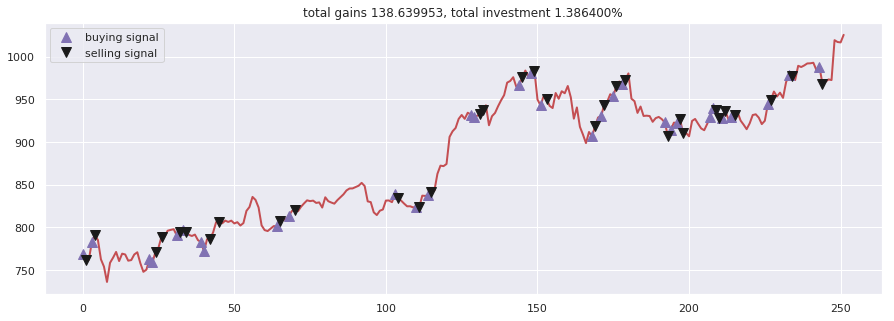

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Actor-critic Duel Recurrent agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Actor-critic Duel Recurrent agent'

class Actor:
    def __init__(self, name, input_size, output_size, size_layer):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, None, input_size))
            self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * size_layer))
            cell = tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
            self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X, cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            tensor_action, tensor_validation = tf.split(self.rnn[:,-1],2,1)
            feed_action = tf.layers.dense(tensor_action, output_size)
            feed_validation = tf.layers.dense(tensor_validation, 1)
            self.logits = feed_validation + tf.subtract(feed_action,
                                                        tf.reduce_mean(feed_action,axis=1,keep_dims=True))

class Critic:
    def __init__(self, name, input_size, output_size, size_layer, learning_rate):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * size_layer))
            self.REWARD = tf.placeholder(tf.float32, (None, 1))
            feed_critic = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            cell = tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
            self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X, cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            tensor_action, tensor_validation = tf.split(self.rnn[:,-1],2,1)
            feed_action = tf.layers.dense(tensor_action, output_size)
            feed_validation = tf.layers.dense(tensor_validation, 1)
            feed_critic = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
            feed_critic = tf.nn.relu(feed_critic) + self.Y
            feed_critic = tf.layers.dense(feed_critic, size_layer//2, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_critic, 1)
            self.cost = tf.reduce_mean(tf.square(self.REWARD - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
            
class Agent:

    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    COPY = 1000
    T_COPY = 0

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.skip = skip
        tf.reset_default_graph()
        self.actor = Actor('actor-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.actor_target = Actor('actor-target', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.critic = Critic('critic-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.critic_target = Critic('critic-target', self.state_size, self.OUTPUT_SIZE, 
                                    self.LAYER_SIZE, self.LEARNING_RATE)
        self.grad_critic = tf.gradients(self.critic.logits, self.critic.Y)
        self.actor_critic_grad = tf.placeholder(tf.float32, [None, self.OUTPUT_SIZE])
        weights_actor = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='actor')
        self.grad_actor = tf.gradients(self.actor.logits, weights_actor, -self.actor_critic_grad)
        grads = zip(self.grad_actor, weights_actor)
        self.optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).apply_gradients(grads)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)
            
    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            prediction = self.sess.run(self.actor.logits, feed_dict={self.actor.X:[state]})[0]
            action = np.argmax(prediction)
        return action
    
    def _construct_memories_and_train(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.actor.logits, feed_dict={self.actor.X: states,
                                                       self.actor.hidden_layer: init_values})
        Q_target = self.sess.run(self.actor_target.logits, feed_dict={self.actor_target.X: states,
                                                                     self.actor_target.hidden_layer: init_values})
        grads = self.sess.run(self.grad_critic, feed_dict={self.critic.X:states, self.critic.Y:Q,
                                                          self.critic.hidden_layer: init_values})[0]
        self.sess.run(self.optimizer, feed_dict={self.actor.X:states, self.actor_critic_grad:grads,
                                                self.actor.hidden_layer: init_values})
        
        rewards = np.array([a[2] for a in replay]).reshape((-1, 1))
        rewards_target = self.sess.run(self.critic_target.logits, 
                                       feed_dict={self.critic_target.X:new_states,self.critic_target.Y:Q_target,
                                                 self.critic_target.hidden_layer: init_values})
        for i in range(len(replay)):
            if not replay[0][-2]:
                rewards[i] += self.GAMMA * rewards_target[i]
        cost, _ = self.sess.run([self.critic.cost, self.critic.optimizer], 
                                feed_dict={self.critic.X:states, self.critic.Y:Q, self.critic.REWARD:rewards,
                                          self.critic.hidden_layer: init_values})
        return cost
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            
            if np.random.rand() < self.EPSILON:
                action = np.random.randint(self.OUTPUT_SIZE)
            else:
                action, last_state = self.sess.run([self.actor.logits,
                                                  self.actor.last_state],
                                                  feed_dict={self.actor.X:[self.INITIAL_FEATURES],
                                                             self.actor.hidden_layer:init_value})
                action, init_value = np.argmax(action[0]), last_state
                    
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('actor-original', 'actor-target')
                    self._assign('critic-original', 'critic-target')
                    
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.actor.logits,
                                                  self.actor.last_state],
                                                  feed_dict={self.actor.X:[self.INITIAL_FEATURES],
                                                             self.actor.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                self.INITIAL_FEATURES = new_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories_and_train(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch: 10, total rewards: 1217.199710.3, cost: 0.428947, total money: 9258.459720
epoch: 20, total rewards: 154.669988.3, cost: 0.205311, total money: 8167.020025
epoch: 30, total rewards: 225.259892.3, cost: 0.080974, total money: 10225.259892
epoch: 40, total rewards: 1857.994754.3, cost: 0.147440, total money: 7906.464724
epoch: 50, total rewards: 864.365355.3, cost: 0.133079, total money: 3145.525327
epoch: 60, total rewards: 252.179754.3, cost: 0.349886, total money: 10252.179754
epoch: 70, total rewards: 2285.265256.3, cost: 0.122869, total money: 841.845272
epoch: 80, total rewards: 2273.160095.3, cost: 0.042144, total money: 1779.580078
epoch: 90, total rewards: 695.794921.3, cost: 0.652829, total money: 10695.794921
epoch: 100, total rewards: -63.870359.3, cost: 0.026901, total money: 9936.129641
epoch: 110, total rewards: 1660.049986.3, cost: 0.050525, total money: 236.529905
epoch: 120, total rewards: 2

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1, sell 1 unit at price 762.130005, investment -0.854691 %, total balance 9993.429993,
day 3: buy 1 unit at price 782.520020, total balance 9210.909973
day 4, sell 1 unit at price 790.510010, investment 1.021059 %, total balance 10001.419983,
day 22: buy 1 unit at price 762.520020, total balance 9238.899963
day 23: buy 1 unit at price 759.109985, total balance 8479.789978
day 24, sell 1 unit at price 771.190002, investment 1.137017 %, total balance 9250.979980,
day 26, sell 1 unit at price 789.289978, investment 3.975708 %, total balance 10040.269958,
day 31: buy 1 unit at price 790.799988, total balance 9249.469970
day 32, sell 1 unit at price 794.200012, investment 0.429947 %, total balance 10043.669982,
day 33: buy 1 unit at price 796.419983, total balance 9247.249999
day 34, sell 1 unit at price 794.559998, investment -0.233543 %, total balance 10041.809997,
day 39: buy 1 unit at price 782.789978, total balance 92

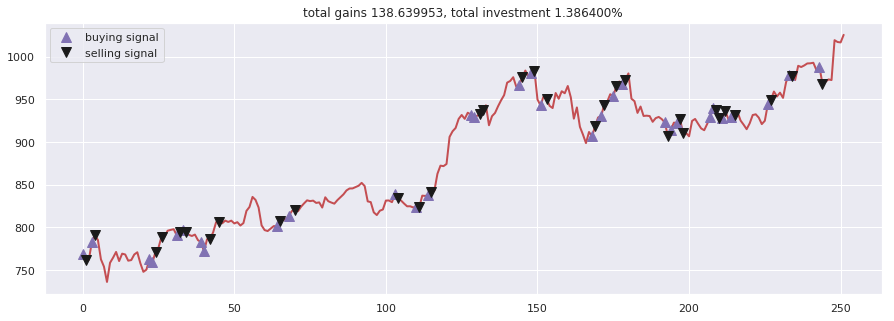

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Curiosity Q-learning agent

In [0]:
from collections import deque
import random


df= df_full.copy()
name = 'Curiosity Q-learning agent'

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, self.state_size))
        self.ACTION = tf.placeholder(tf.float32, (None))
        self.REWARD = tf.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(self.ACTION)[0]
        
        with tf.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1))
            state_action = tf.concat([self.X, action], axis=1)
            save_state = tf.identity(self.Y)
            
            feed = tf.layers.dense(state_action, 32, activation=tf.nn.relu)
            self.curiosity_logits = tf.layers.dense(feed, self.state_size)
            self.curiosity_cost = tf.reduce_sum(tf.square(save_state - self.curiosity_logits), axis=1)
            
            self.curiosity_optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(self.curiosity_cost))
        
        total_reward = tf.add(self.curiosity_cost, self.REWARD)
        
        with tf.variable_scope("q_model"):
            with tf.variable_scope("eval_net"):
                x_action = tf.layers.dense(self.X, 128, tf.nn.relu)
                self.logits = tf.layers.dense(x_action, self.OUTPUT_SIZE)
            
            with tf.variable_scope("target_net"):
                y_action = tf.layers.dense(self.Y, 128, tf.nn.relu)
                y_q = tf.layers.dense(y_action, self.OUTPUT_SIZE)
            
            q_target = total_reward + self.GAMMA * tf.reduce_max(y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.losses.mean_squared_error(labels=q_target, predictions=q)
            self.optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))
            
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action
    
    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)
            
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
        })
        
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
            })
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 2349.819823.3, cost: 69092.625000, total money: 12349.819823
epoch: 20, total rewards: 648.444882.3, cost: 4775652.000000, total money: 6742.654903
epoch: 30, total rewards: 1543.784977.3, cost: 26533.583984, total money: 7642.034916
epoch: 40, total rewards: 1360.930418.3, cost: 871420.750000, total money: 695.580380
epoch: 50, total rewards: 2233.069826.3, cost: 228718.296875, total money: 6354.209779
epoch: 60, total rewards: 1573.414983.3, cost: 407432.843750, total money: 8625.614995
epoch: 70, total rewards: -7.114931.3, cost: 32132.660156, total money: 5021.405088
epoch: 80, total rewards: 798.045042.3, cost: 435778.562500, total money: 9780.935057
epoch: 90, total rewards: 575.719967.3, cost: 72847.468750, total money: 9559.079952
epoch: 100, total rewards: 338.655157.3, cost: 379671.968750, total money: 820.245184
epoch: 110, total rewards: 277.220155.3, cost: 391019.375000, total money: 3452.330140
epoch: 120, total rewards: 370.379826.3, cost: 42996

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 7: buy 1 unit at price 754.020020, total balance 9245.979980
day 8: buy 1 unit at price 736.080017, total balance 8509.899963
day 9: buy 1 unit at price 758.489990, total balance 7751.409973
day 10: buy 1 unit at price 764.479980, total balance 6986.929993
day 11: buy 1 unit at price 771.229980, total balance 6215.700013
day 15, sell 1 unit at price 760.989990, investment 0.924375 %, total balance 6976.690003,
day 18: buy 1 unit at price 770.840027, total balance 6205.849976
day 19: buy 1 unit at price 758.039978, total balance 5447.809998
day 22: buy 1 unit at price 762.520020, total balance 4685.289978
day 23: buy 1 unit at price 759.109985, total balance 3926.179993
day 24, sell 1 unit at price 771.190002, investment 4.769860 %, total balance 4697.369995,
day 27: buy 1 unit at price 789.270020, total balance 3908.099975
day 28, sell 1 unit at price 796.099976, investment 4.958534 %, total balance 4704.199951,
day 29: buy 1 unit at price 797.070007, total balance 3907.129944
day 

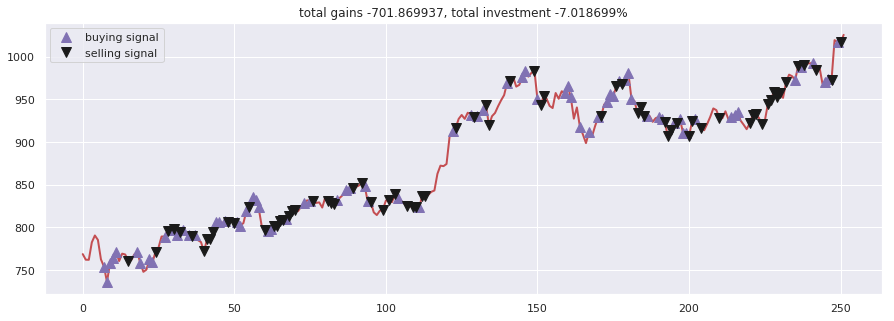

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Recurrent Curiosity Q-learning agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Recurrent Curiosity Q-learning agent'

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 128
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.X = tf.placeholder(tf.float32, (None, None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, None, self.state_size))
        self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * self.LAYER_SIZE))
        self.ACTION = tf.placeholder(tf.float32, (None))
        self.REWARD = tf.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(self.ACTION)[0]
        self.seq_len = tf.shape(self.X)[1]
        
        with tf.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1,1))
            repeat_action = tf.tile(action, [1,self.seq_len,1])
            state_action = tf.concat([self.X, repeat_action], axis=-1)
            save_state = tf.identity(self.Y)
            cell = tf.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
            self.rnn,last_state = tf.nn.dynamic_rnn(inputs=state_action,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            self.curiosity_logits = tf.layers.dense(self.rnn[:,-1], self.state_size)
            self.curiosity_cost = tf.reduce_sum(tf.square(save_state[:,-1] - self.curiosity_logits), axis=1)
            
            self.curiosity_optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(self.curiosity_cost))
        
        total_reward = tf.add(self.curiosity_cost, self.REWARD)
        
        with tf.variable_scope("q_model"):
            with tf.variable_scope("eval_net"):
                cell = tf.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
                rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
                self.logits = tf.layers.dense(rnn[:,-1], self.OUTPUT_SIZE)
            
            with tf.variable_scope("target_net"):
                cell = tf.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
                rnn,last_state = tf.nn.dynamic_rnn(inputs=self.Y,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
                y_q = tf.layers.dense(rnn[:,-1], self.OUTPUT_SIZE)
            
            q_target = total_reward + self.GAMMA * tf.reduce_max(y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.losses.mean_squared_error(labels=q_target, predictions=q)
            self.optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))
            
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, done, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, done, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)
            
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards,
            self.hidden_layer: init_values
        })
        
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards,
                self.hidden_layer: init_values
            })
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            
            if np.random.rand() < self.EPSILON:
                action = np.random.randint(self.OUTPUT_SIZE)
            else:
                action, last_state = self.sess.run([self.logits,
                                                  self.last_state],
                                                  feed_dict={self.X:[self.INITIAL_FEATURES],
                                                             self.hidden_layer:init_value})
                action, init_value = np.argmax(action[0]), last_state
                    
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.logits,
                                                  self.last_state],
                                                  feed_dict={self.X:[self.INITIAL_FEATURES],
                                                             self.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 685.860168.3, cost: 4139534.500000, total money: 977.580137
epoch: 20, total rewards: 1724.255003.3, cost: 5132677.500000, total money: 5851.904966
epoch: 30, total rewards: 493.970035.3, cost: 3979546.750000, total money: 8528.600039
epoch: 40, total rewards: 1580.255128.3, cost: 5099559.000000, total money: 4018.855103
epoch: 50, total rewards: 1467.990231.3, cost: 4410721.500000, total money: 8490.720211
epoch: 60, total rewards: 1285.420161.3, cost: 3993190.000000, total money: 2688.440118
epoch: 70, total rewards: 391.130068.3, cost: 3420379.000000, total money: 6491.710085
epoch: 80, total rewards: 1276.110108.3, cost: 3443612.750000, total money: 3698.110047
epoch: 90, total rewards: 672.475340.3, cost: 2882908.000000, total money: 208.605285
epoch: 100, total rewards: 706.604982.3, cost: 3108476.500000, total money: 1169.724916
epoch: 110, total rewards: 979.940367.3, cost: 2024909.750000, total money: 3200.720335
epoch: 120, total rewards: 853.199893.

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1, sell 1 unit at price 762.130005, investment -0.854691 %, total balance 9993.429993,
day 4: buy 1 unit at price 790.510010, total balance 9202.919983
day 5: buy 1 unit at price 785.309998, total balance 8417.609985
day 8: buy 1 unit at price 736.080017, total balance 7681.529968
day 9: buy 1 unit at price 758.489990, total balance 6923.039978
day 11, sell 1 unit at price 771.229980, investment -2.438936 %, total balance 7694.269958,
day 13: buy 1 unit at price 769.200012, total balance 6925.069946
day 17: buy 1 unit at price 768.239990, total balance 6156.829956
day 19, sell 1 unit at price 758.039978, investment -3.472517 %, total balance 6914.869934,
day 25, sell 1 unit at price 776.419983, investment 5.480378 %, total balance 7691.289917,
day 26: buy 1 unit at price 789.289978, total balance 6901.999939
day 28: buy 1 unit at price 796.099976, total balance 6105.899963
day 31: buy 1 unit at price 790.799988, total

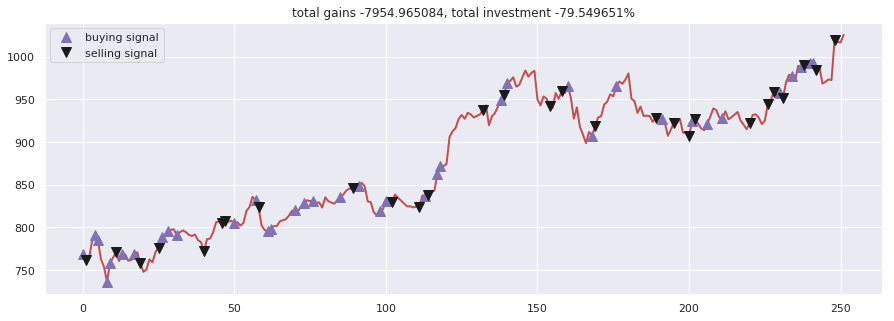

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Duel Curiosity Q-learning agent

In [0]:
from collections import deque
import random

df= df_full.copy()
name = 'Duel Curiosity Q-learning agent'

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, self.state_size))
        self.ACTION = tf.placeholder(tf.float32, (None))
        self.REWARD = tf.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(self.ACTION)[0]
        
        with tf.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1))
            state_action = tf.concat([self.X, action], axis=1)
            save_state = tf.identity(self.Y)
            
            feed = tf.layers.dense(state_action, 32, activation=tf.nn.relu)
            self.curiosity_logits = tf.layers.dense(feed, self.state_size)
            self.curiosity_cost = tf.reduce_sum(tf.square(save_state - self.curiosity_logits), axis=1)
            
            self.curiosity_optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(self.curiosity_cost))
        
        total_reward = tf.add(self.curiosity_cost, self.REWARD)
        
        with tf.variable_scope("q_model"):
            with tf.variable_scope("eval_net"):
                x_action = tf.layers.dense(self.X, 128, tf.nn.relu)
                tensor_action, tensor_validation = tf.split(x_action,2,1)
                feed_action = tf.layers.dense(tensor_action, self.OUTPUT_SIZE)
                feed_validation = tf.layers.dense(tensor_validation, 1)
                self.logits = feed_validation + \
                tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
            
            with tf.variable_scope("target_net"):
                y_action = tf.layers.dense(self.Y, 128, tf.nn.relu)
                tensor_action, tensor_validation = tf.split(y_action,2,1)
                feed_action = tf.layers.dense(tensor_action, self.OUTPUT_SIZE)
                feed_validation = tf.layers.dense(tensor_validation, 1)
                y_q = feed_validation + \
                tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
            
            q_target = total_reward + self.GAMMA * tf.reduce_max(y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.losses.mean_squared_error(labels=q_target, predictions=q)
            self.optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))
            
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action
    
    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)
            
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
        })
        
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
            })
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [0]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
epoch: 10, total rewards: 698.460085.3, cost: 596251.000000, total money: 10698.460085
epoch: 20, total rewards: 1683.164917.3, cost: 5890915.500000, total money: 6720.204895
epoch: 30, total rewards: 1686.875004.3, cost: 75077.554688, total money: 6721.424992
epoch: 40, total rewards: 541.999876.3, cost: 2707843.750000, total money: 9525.359861
epoch: 50, total rewards: 1668.824950.3, cost: 32719.388672, total money: 7666.774900
epoch: 60, total rewards: 751.654909.3, cost: 1165742.750000, total money: 8743.134889
epoch: 70, total rewards: 1637.889772.3, cost: 325201.937500, total money: 6669.909730
epoch: 80, total rewards: 587.055053.3, cost: 1527037.250000, total money: 892.705077
epoch: 90, total rewards: 2170.969727.3, cost: 122936.546875, total money: 8204.549683
epoch: 100, total rewards: 1565.850155.3, cost: 844705.187500, total money: 19.270138
epoch: 110, total rewards: 1733.244930.3, cost: 557043.12500

In [0]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 782.520020, total balance 9217.479980
day 4: buy 1 unit at price 790.510010, total balance 8426.969970
day 5: buy 1 unit at price 785.309998, total balance 7641.659972
day 6: buy 1 unit at price 762.559998, total balance 6879.099974
day 7: buy 1 unit at price 754.020020, total balance 6125.079954
day 9: buy 1 unit at price 758.489990, total balance 5366.589964
day 10, sell 1 unit at price 764.479980, investment -2.305377 %, total balance 6131.069944,
day 11: buy 1 unit at price 771.229980, total balance 5359.839964
day 13: buy 1 unit at price 769.200012, total balance 4590.639952
day 15: buy 1 unit at price 760.989990, total balance 3829.649962
day 16: buy 1 unit at price 761.679993, total balance 3067.969969
day 17: buy 1 unit at price 768.239990, total balance 2299.729979
day 19: buy 1 unit at price 758.039978, total balance 1541.690001
day 21: buy 1 unit at price 750.500000, total balance 791.190001
day 22, sell 1 unit at price 762.520020, investment -3.54

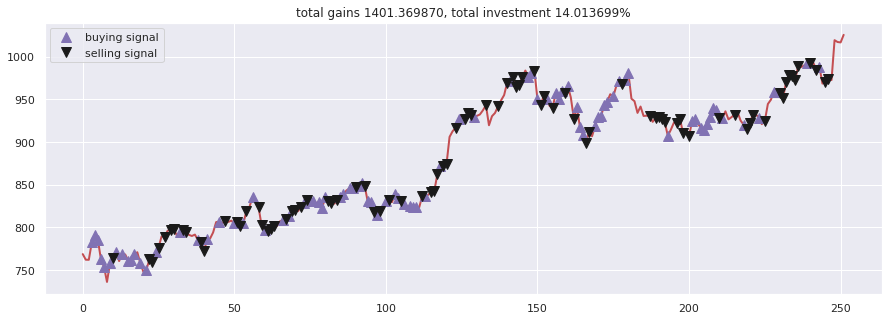

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

# 4 Neuro-evolution

## Neuro-evolution agent

In [0]:
df= df_full.copy()
name = 'Neuro-evolution agent'

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

In [0]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_

def relu(X):
    return np.maximum(X, 0)
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [0]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
    
    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            fitnesses = [i.fitness for i in self.population]
            sort_fitness = np.argsort(fitnesses)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        return fittest_individual

In [0]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)

In [0]:
fittest_nets = neural_evolve.evolve(50)

epoch 5, fittest individual 0 with accuracy 10.849749
epoch 10, fittest individual 0 with accuracy 11.095000
epoch 15, fittest individual 0 with accuracy 11.095000
epoch 20, fittest individual 93 with accuracy 13.756802
epoch 25, fittest individual 95 with accuracy 23.728605
epoch 30, fittest individual 0 with accuracy 23.728605
epoch 35, fittest individual 0 with accuracy 23.728605
epoch 40, fittest individual 0 with accuracy 23.728605
epoch 45, fittest individual 0 with accuracy 23.728605
epoch 50, fittest individual 0 with accuracy 23.728605


In [0]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets)

day 1: buy 1 unit at price 762.130005, total balance 9237.869995
day 2: buy 1 unit at price 762.020020, total balance 8475.849975
day 3, sell 1 unit at price 782.520020, investment 2.675399 %, total balance 9258.369995,
day 5, sell 1 unit at price 785.309998, investment 3.056347 %, total balance 10043.679993,
day 6: buy 1 unit at price 762.559998, total balance 9281.119995
day 7: buy 1 unit at price 754.020020, total balance 8527.099975
day 8: buy 1 unit at price 736.080017, total balance 7791.019958
day 9: buy 1 unit at price 758.489990, total balance 7032.529968
day 10, sell 1 unit at price 764.479980, investment 0.251781 %, total balance 7797.009948,
day 12: buy 1 unit at price 760.539978, total balance 7036.469970
day 14: buy 1 unit at price 768.270020, total balance 6268.199950
day 15: buy 1 unit at price 760.989990, total balance 5507.209960
day 16: buy 1 unit at price 761.679993, total balance 4745.529967
day 17, sell 1 unit at price 768.239990, investment 1.885888 %, total bala

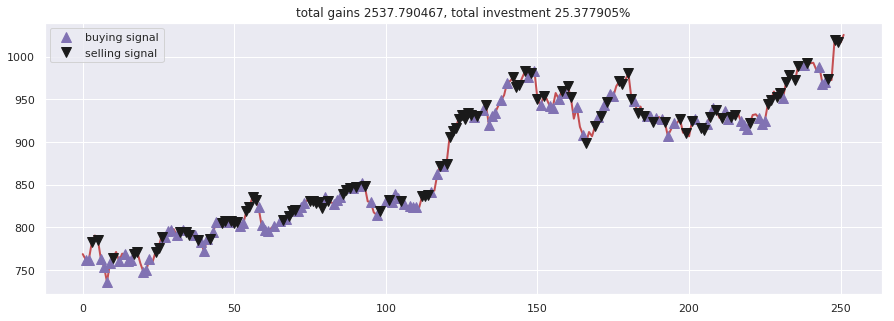

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## Neuro-evolution with Novelty search agent

In [0]:
df= df_full.copy()
name = 'Neuro-evolution with Novelty search agent'

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

novelty_search_threshold = 6
novelty_log_maxlen = 1000
backlog_maxsize = 500
novelty_log_add_amount = 3

In [0]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.last_features = None
        self.id = id_

def relu(X):
    return np.maximum(X, 0)
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [0]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.generation_backlog = []
        self.novel_backlog = []
        self.novel_pop = []
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def _memorize(self, q, i, limit):
        q.append(i)
        if len(q) > limit:
            q.pop()
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
            self.population[i].last_features = self.population[i].W2.flatten()
    
    def evaluate(self, individual, backlog, pop, k = 4):
        score = 0
        if len(backlog):
            x = np.array(backlog)
            nn = NearestNeighbors(n_neighbors = k, metric = 'euclidean').fit(np.array(backlog))
            d, _ = nn.kneighbors([individual])
            score += np.mean(d)
        
        if len(pop):
            nn = NearestNeighbors(n_neighbors = k, metric = 'euclidean').fit(np.array(pop))
            d, _ = nn.kneighbors([individual])
            score += np.mean(d)
        
        return score
    
    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            scores = [self.evaluate(p.last_features, self.novel_backlog, self.novel_pop) for p in self.population]
            sort_fitness = np.argsort(scores)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            
            for p in next_population:
                if p.last_features is not None:
                    self._memorize(self.novel_pop, p.last_features, backlog_maxsize)
                    if np.random.randint(0,10) < novelty_search_threshold:
                        self._memorize(self.novel_backlog, p.last_features, novelty_log_maxlen)
                        
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
            
            if np.random.randint(0,10) < novelty_search_threshold:
                pop_sorted = sorted(self.population, key=lambda p: p.fitness, reverse=True)
                self.generation_backlog.append(pop_sorted[0])
                print('novel add fittest, score: %f, backlog size: %d'%(pop_sorted[0].fitness, 
                                                                        len(self.generation_backlog)))
                generation_backlog_temp = self.generation_backlog
                if len(self.generation_backlog) > backlog_maxsize:
                    generation_backlog_temp = random.sample(generation_backlog, backlog_maxsize)
                for p in generation_backlog_temp:
                    if p.last_features is not None:
                        self._memorize(self.novel_backlog, p.last_features, novelty_log_maxlen)
                        
        return fittest_individual

In [0]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)

In [0]:
fittest_nets = neural_evolve.evolve(100)

novel add fittest, score: 5.960001, backlog size: 16
novel add fittest, score: 2.560349, backlog size: 17
epoch 5, fittest individual 86 with accuracy -99.353801
novel add fittest, score: 2.073401, backlog size: 18
epoch 10, fittest individual 53 with accuracy -99.622801
novel add fittest, score: 9.773855, backlog size: 19
novel add fittest, score: 1.068502, backlog size: 20
novel add fittest, score: 1.733602, backlog size: 21
epoch 15, fittest individual 49 with accuracy -94.018300
novel add fittest, score: 1.439049, backlog size: 22
novel add fittest, score: 0.000000, backlog size: 23
novel add fittest, score: 0.000000, backlog size: 24
novel add fittest, score: 3.052850, backlog size: 25
epoch 20, fittest individual 83 with accuracy -42.284500
novel add fittest, score: 3.284498, backlog size: 26
novel add fittest, score: 3.284498, backlog size: 27
novel add fittest, score: 0.000000, backlog size: 28
novel add fittest, score: 0.000000, backlog size: 29
epoch 25, fittest individual 43

In [0]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets)

day 1: buy 1 unit at price 762.130005, total balance 9237.869995
day 3: buy 1 unit at price 782.520020, total balance 8455.349975
day 4: buy 1 unit at price 790.510010, total balance 7664.839965
day 5, sell 1 unit at price 785.309998, investment 3.041475 %, total balance 8450.149963,
day 9: buy 1 unit at price 758.489990, total balance 7691.659973
day 10: buy 1 unit at price 764.479980, total balance 6927.179993
day 11: buy 1 unit at price 771.229980, total balance 6155.950013
day 15: buy 1 unit at price 760.989990, total balance 5394.960023
day 16: buy 1 unit at price 761.679993, total balance 4633.280030
day 17: buy 1 unit at price 768.239990, total balance 3865.040040
day 21: buy 1 unit at price 750.500000, total balance 3114.540040
day 26, sell 1 unit at price 789.289978, investment 0.865148 %, total balance 3903.830018,
day 31: buy 1 unit at price 790.799988, total balance 3113.030030
day 37: buy 1 unit at price 791.549988, total balance 2321.480042
day 39: buy 1 unit at price 782

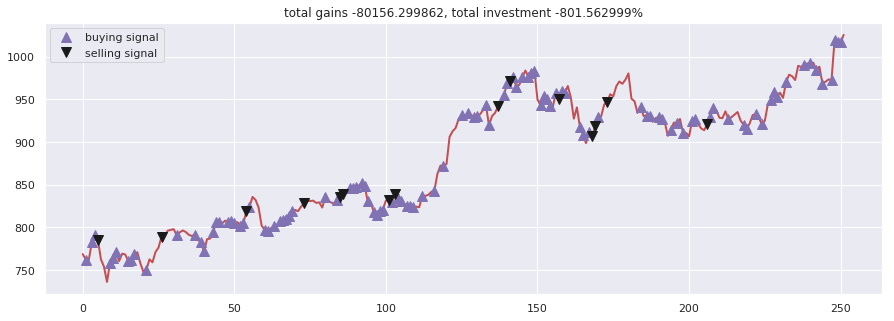

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

## ABCD strategy agent

In [0]:
df= df_full.copy()
name = 'ABCD strategy agent'

def abcd(trend, skip_loop = 4, ma = 7):
    ma = pd.Series(trend).rolling(ma).mean().values
    x = []
    for a in range(ma.shape[0]):
        for b in range(a, ma.shape[0], skip_loop):
            for c in range(b, ma.shape[0], skip_loop):
                for d in range(c, ma.shape[0], skip_loop):
                    if ma[b] > ma[a] and \
                    (ma[c] < ma[b] and ma[c] > ma[a]) \
                    and ma[d] > ma[b]:
                        x.append([a,b,c,d])
    x_np = np.array(x)
    ac = x_np[:,0].tolist() + x_np[:,2].tolist()
    bd = x_np[:,1].tolist() + x_np[:,3].tolist()
    ac_set = set(ac)
    bd_set = set(bd)
    signal = np.zeros(len(trend))
    buy = list(ac_set - bd_set)
    sell = list(list(bd_set - ac_set))
    signal[buy] = 1.0
    signal[sell] = -1.0
    return signal

In [0]:
%%time
signal = abcd(df['Close'])

CPU times: user 1.08 s, sys: 8 ms, total: 1.09 s
Wall time: 1.09 s


In [0]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 10000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    states_money = []
    current_inventory = 0
    
    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory
    
    for i in range(real_movement.shape[0]):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
        states_money.append(initial_money)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, states_money

In [0]:
states_buy, states_sell, total_gains, invest, states_money = buy_stock(df.Close, signal)

day 6: buy 1 units at price 762.559998, total balance 9237.440002
day 7: buy 1 units at price 754.020020, total balance 8483.419982
day 8: buy 1 units at price 736.080017, total balance 7747.339965
day 9: buy 1 units at price 758.489990, total balance 6988.849975
day 10: buy 1 units at price 764.479980, total balance 6224.369995
day 11: buy 1 units at price 771.229980, total balance 5453.140015
day 12: buy 1 units at price 760.539978, total balance 4692.600037
day 13: buy 1 units at price 769.200012, total balance 3923.400025
day 14: buy 1 units at price 768.270020, total balance 3155.130005
day 15: buy 1 units at price 760.989990, total balance 2394.140015
day 19: buy 1 units at price 758.039978, total balance 1636.100037
day 21: buy 1 units at price 750.500000, total balance 885.600037
day 22: buy 1 units at price 762.520020, total balance 123.080017
day 23: total balances 123.080017, not enough money to buy a unit price 759.109985
day 24: total balances 123.080017, not enough money 

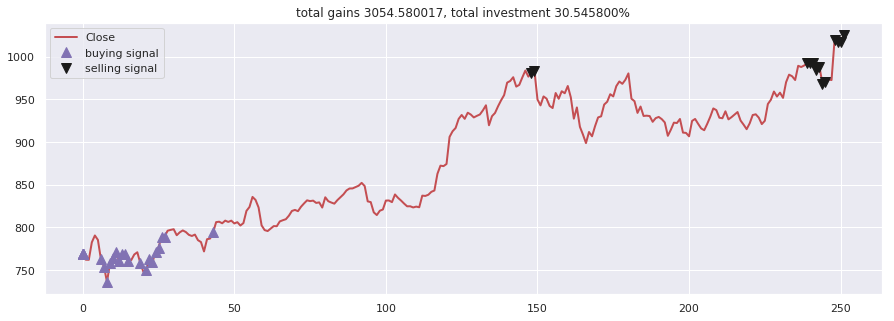

In [0]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

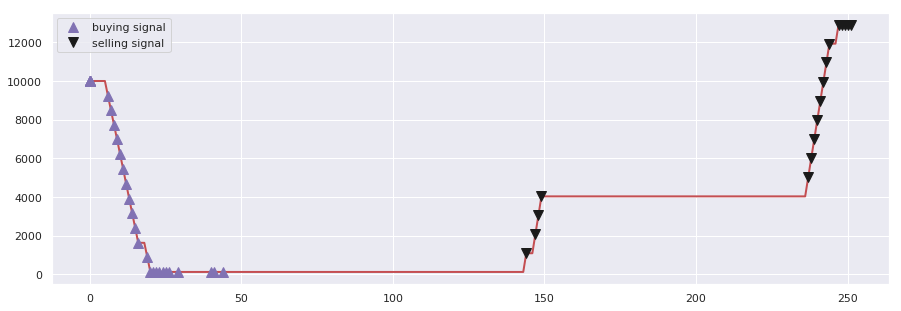

In [0]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_money, color='r', lw=2.)
plt.plot(states_money, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(states_money, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.show()

## Deep Evolution Strategy

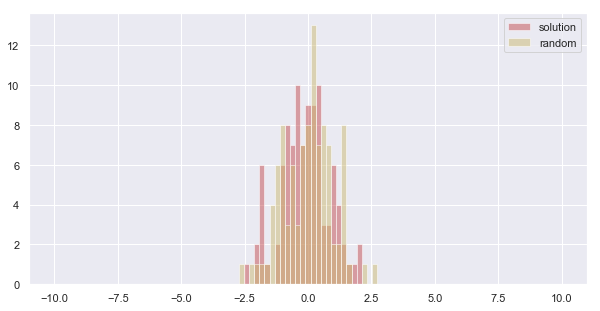

In [0]:
plt.figure(figsize = (10, 5))
bins = np.linspace(-10, 10, 100)

solution = np.random.randn(100)
w = np.random.randn(100)

plt.hist(solution, bins, alpha = 0.5, label = 'solution', color = 'r')
plt.hist(w, bins, alpha = 0.5, label = 'random', color = 'y')
plt.legend()
plt.show()

In [0]:
def f(w):
    return -np.sum(np.square(solution - w))


npop = 50
sigma = 0.1
alpha = 0.001

for i in range(5000):

    if (i + 1) % 1000 == 0:
        print(
            'iter %d. w: %s, solution: %s, reward: %f'
            % (i + 1, str(w[-1]), str(solution[-1]), f(w))
        )
    N = np.random.randn(npop, 100)
    R = np.zeros(npop)
    for j in range(npop):
        w_try = w + sigma * N[j]
        R[j] = f(w_try)

    A = (R - np.mean(R)) / np.std(R)
    w = w + alpha / (npop * sigma) * np.dot(N.T, A)

iter 1000. w: 0.0952791586701015, solution: 0.5720518054873052, reward: -20.148099
iter 2000. w: 0.5750455468679501, solution: 0.5720518054873052, reward: -0.008058
iter 3000. w: 0.5751585748688035, solution: 0.5720518054873052, reward: -0.008793
iter 4000. w: 0.5665604300033952, solution: 0.5720518054873052, reward: -0.007711
iter 5000. w: 0.5619489293298067, solution: 0.5720518054873052, reward: -0.005604


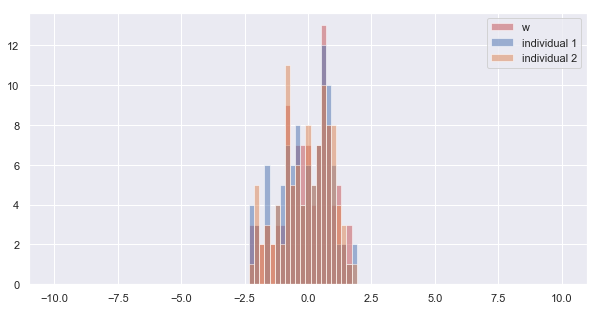

In [0]:
'''
I want to compare my first two individuals with my real w
'''
plt.figure(figsize=(10,5))

sigma = 0.1
N = np.random.randn(npop, 100)
individuals = []
for j in range(2):
    individuals.append(w + sigma * N[j])
    
    
plt.hist(w, bins, alpha=0.5, label='w',color='r')
plt.hist(individuals[0], bins, alpha=0.5, label='individual 1')
plt.hist(individuals[1], bins, alpha=0.5, label='individual 2')
plt.legend()
plt.show()

In [0]:
df= df_full.copy()
name = 'Deep Evolution Strategy'

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-16,992.099976,993.906982,984.000000,992.000000,992.000000,910500
1,2017-10-17,990.289978,996.440002,988.590027,992.179993,992.179993,1290200
2,2017-10-18,991.770020,996.719971,986.974976,992.809998,992.809998,1057600
3,2017-10-19,986.000000,988.880005,978.390015,984.450012,984.450012,1313600
4,2017-10-20,989.440002,991.000000,984.580017,988.200012,988.200012,1183200


In [0]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [0]:
close = df.Close.values.tolist()
get_state(close, 0, 10)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [0]:
get_state(close, 1, 10)

array([[0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.179993]])

In [0]:
get_state(close, 2, 10)

array([[0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.179993, 0.630005]])

In [0]:
class Deep_Evolution_Strategy:
    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')

In [0]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
window_size = 30
model = Model(window_size, 500, 3)

In [0]:
initial_money = 10000
starting_money = initial_money
len_close = len(close) - 1
weight = model
skip = 1

state = get_state(close, 0, window_size + 1)
inventory = []
quantity = 0

max_buy = 5
max_sell = 5


def act(model, sequence):
    decision, buy = model.predict(np.array(sequence))
    return np.argmax(decision[0]), int(buy[0])


for t in range(0, len_close, skip):
    action, buy = act(weight, state)
    next_state = get_state(close, t + 1, window_size + 1)
    if action == 1 and initial_money >= close[t]:
        if buy < 0:
            buy = 1
        if buy > max_buy:
            buy_units = max_buy
        else:
            buy_units = buy
        total_buy = buy_units * close[t]
        initial_money -= total_buy
        inventory.append(total_buy)
        quantity += buy_units
    elif action == 2 and len(inventory) > 0:
        if quantity > max_sell:
            sell_units = max_sell
        else:
            sell_units = quantity
        quantity -= sell_units
        total_sell = sell_units * close[t]
        initial_money += total_sell

    state = next_state
((initial_money - starting_money) / starting_money) * 100

-89.2658852200001

In [0]:
import time


class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, max_buy, max_sell, close, window_size, skip
    ):
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.savefig('output/'+name+'.png')
        plt.show()

In [0]:
model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(
    model = model,
    money = 10000,
    max_buy = 5,
    max_sell = 5,
    close = close,
    window_size = window_size,
    skip = 1,
)

In [0]:
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 36.181611
iter 20. reward: 50.767101
iter 30. reward: 65.467698
iter 40. reward: 71.316103
iter 50. reward: 82.881994
iter 60. reward: 84.293704
iter 70. reward: 78.501997
iter 80. reward: 94.488579
iter 90. reward: 86.526799
iter 100. reward: 85.882890
iter 110. reward: 86.063284
iter 120. reward: 90.334301
iter 130. reward: 85.850098
iter 140. reward: 91.399606
iter 150. reward: 87.862805
iter 160. reward: 97.226486
iter 170. reward: 86.767297
iter 180. reward: 97.016782
iter 190. reward: 97.843791
iter 200. reward: 89.146606
iter 210. reward: 96.508885
iter 220. reward: 97.765979
iter 230. reward: 98.256375
iter 240. reward: 99.942482
iter 250. reward: 94.536183
iter 260. reward: 96.916185
iter 270. reward: 93.193185
iter 280. reward: 100.844085
iter 290. reward: 100.994682
iter 300. reward: 101.523774
iter 310. reward: 102.090896
iter 320. reward: 102.176091
iter 330. reward: 92.306981
iter 340. reward: 105.409190
iter 350. reward: 103.159886
iter 360. reward: 99.0

day 0: buy 1 units at price 992.000000, total balance 9008.000000
day 1: buy 1 units at price 992.179993, total balance 8015.820007
day 2: buy 1 units at price 992.809998, total balance 7023.010009
day 3: buy 5 units at price 4922.250060, total balance 2100.759949
day 4, sell 5 units at price 4941.000060, investment 398.084683 %, total balance 7041.760009,
day 5: buy 5 units at price 4842.250060, total balance 2199.509949
day 7: buy 5 units at price 4866.650085, total balance -2667.140136
day 9, sell 5 units at price 5096.350100, investment 413.651770 %, total balance 2429.209964,
day 10: buy 5 units at price 5085.549925, total balance -2656.339961
day 12, sell 5 units at price 5127.500000, investment 416.463373 %, total balance 2471.160039,
day 13, sell 5 units at price 5127.899780, investment 4.177962 %, total balance 7599.059819,
day 14, sell 3 units at price 3097.439940, investment -36.033045 %, total balance 10696.499759,
day 22: buy 1 units at price 1020.909973, total balance 967

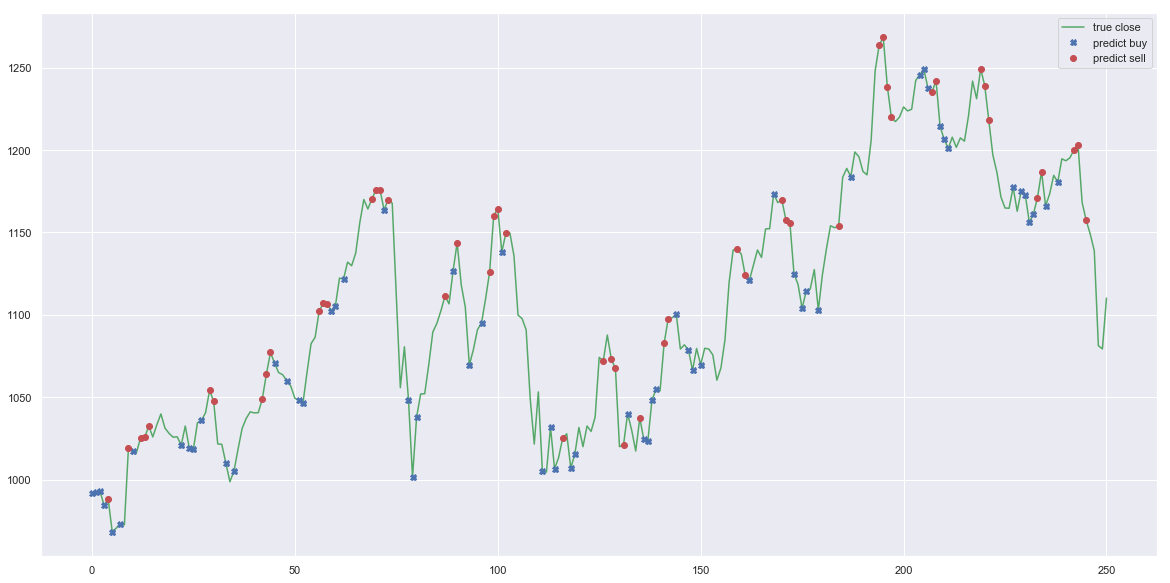

In [0]:
agent.buy()